In [1]:
# imports needed for propeR
TRANSPORT= False
if TRANSPORT:
    from rpy2.robjects import pandas2ri, numpy2ri
    pandas2ri.activate()
    numpy2ri.activate()
    from rpy2.robjects.packages import importr
    propeR = importr('propeR')

# general imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os
import pickle
from importlib import reload
import random
import tempfile
import shutil
from geopy.distance import geodesic

# transport
if TRANSPORT:
    import requests

%matplotlib inline

In [2]:
# import all filenames (stored in a file that is in common to multiple scripts)
import all_filenames
from all_filenames import *

In [3]:
import utils_pin
from utils_pin import print_elapsed#, draw_map, draw_map_and_landmarks
importMAP = True
if importMAP:
    import maputils_pin
    from maputils_pin import draw_map, draw_map_and_landmarks

In [12]:
# set up Arial as default fontname
plt.rcParams['font.family'] = 'Arial'

In [4]:
# plot saving folder
plot_save_dir = '/Users/stefgarasto/Google Drive/Documents/results/PIN/plots/propeR/'
# file where I'm storing all the information
save_oa_file = res_folder + 'PIN/oa_distances_and_occupations_v2.pickle'
save_oa_file_jobs = res_folder + 'PIN/oa_jobs_breakdown.pickle'
tmp_proper_folder = res_folder + 'PIN/tmp-propeR-data'
tmp_proper_results = res_folder + 'PIN/tmp-propeR-res'
avg_travel_times_ons = data_folder + 'ONS/datalookingattraveltoworkmethodsandusualhometoworktraveltime.xls'
lsoa_to_utla_file = data_folder + 'ONS/Lower_Layer_Super_Output_Area_2011_to_Upper_Tier_Local_Authorities_2017_Lookup_in_England_and_Wales_v2.csv'
ons_pc_file = data_folder + 'ONS/OA_to_LSOA_to_MSOA_to_LAD_December2017_Great_Britain.csv'
SAVEFIG = True

In [6]:
# load the lookup table
lsoa_to_lad = pd.read_csv(ons_pc_file)
# aggregate by LSOA and only keep the first LAD (it might not be exact, since the allocation unit is the postcode)
lsoa_to_lad = lsoa_to_lad[['LAD17CD','LAD17NM','LSOA11CD','LSOA11NM']].groupby(by= 'LSOA11CD', 
                                                                    as_index = False).agg(lambda x: x.iloc[0])

In [7]:
#lsoa_to_utla = pd.read_csv(lsoa_to_utla_file)
#lsoa_to_utla[lsoa_to_utla['UTLA18NM'] == 'North Somerset'].iloc[:4]

                Unnamed: 0  Car,van,minibus,works van  \
0          09 Bedfordshire                     566583   
1     E06000001 Hartlepool                      24259   
2  E06000002 Middlesbrough                      42883   

   Motorbike,moped,scooter  Bicycle  Bus,coach,private bus  Taxi  \
0                        *     6011                  27502  4530   
1                        -        -                      *     -   
2                        -        -                   3173     -   

   Railway train  Underground train,light railway,tram   Walk  Other method  \
0          14876                                     -  47242          3892   
1              -                                     -   2053             -   
2              *                                     -   5924             -   

        Mean  
0  22.823576  
1  27.991328  
2  24.084517  


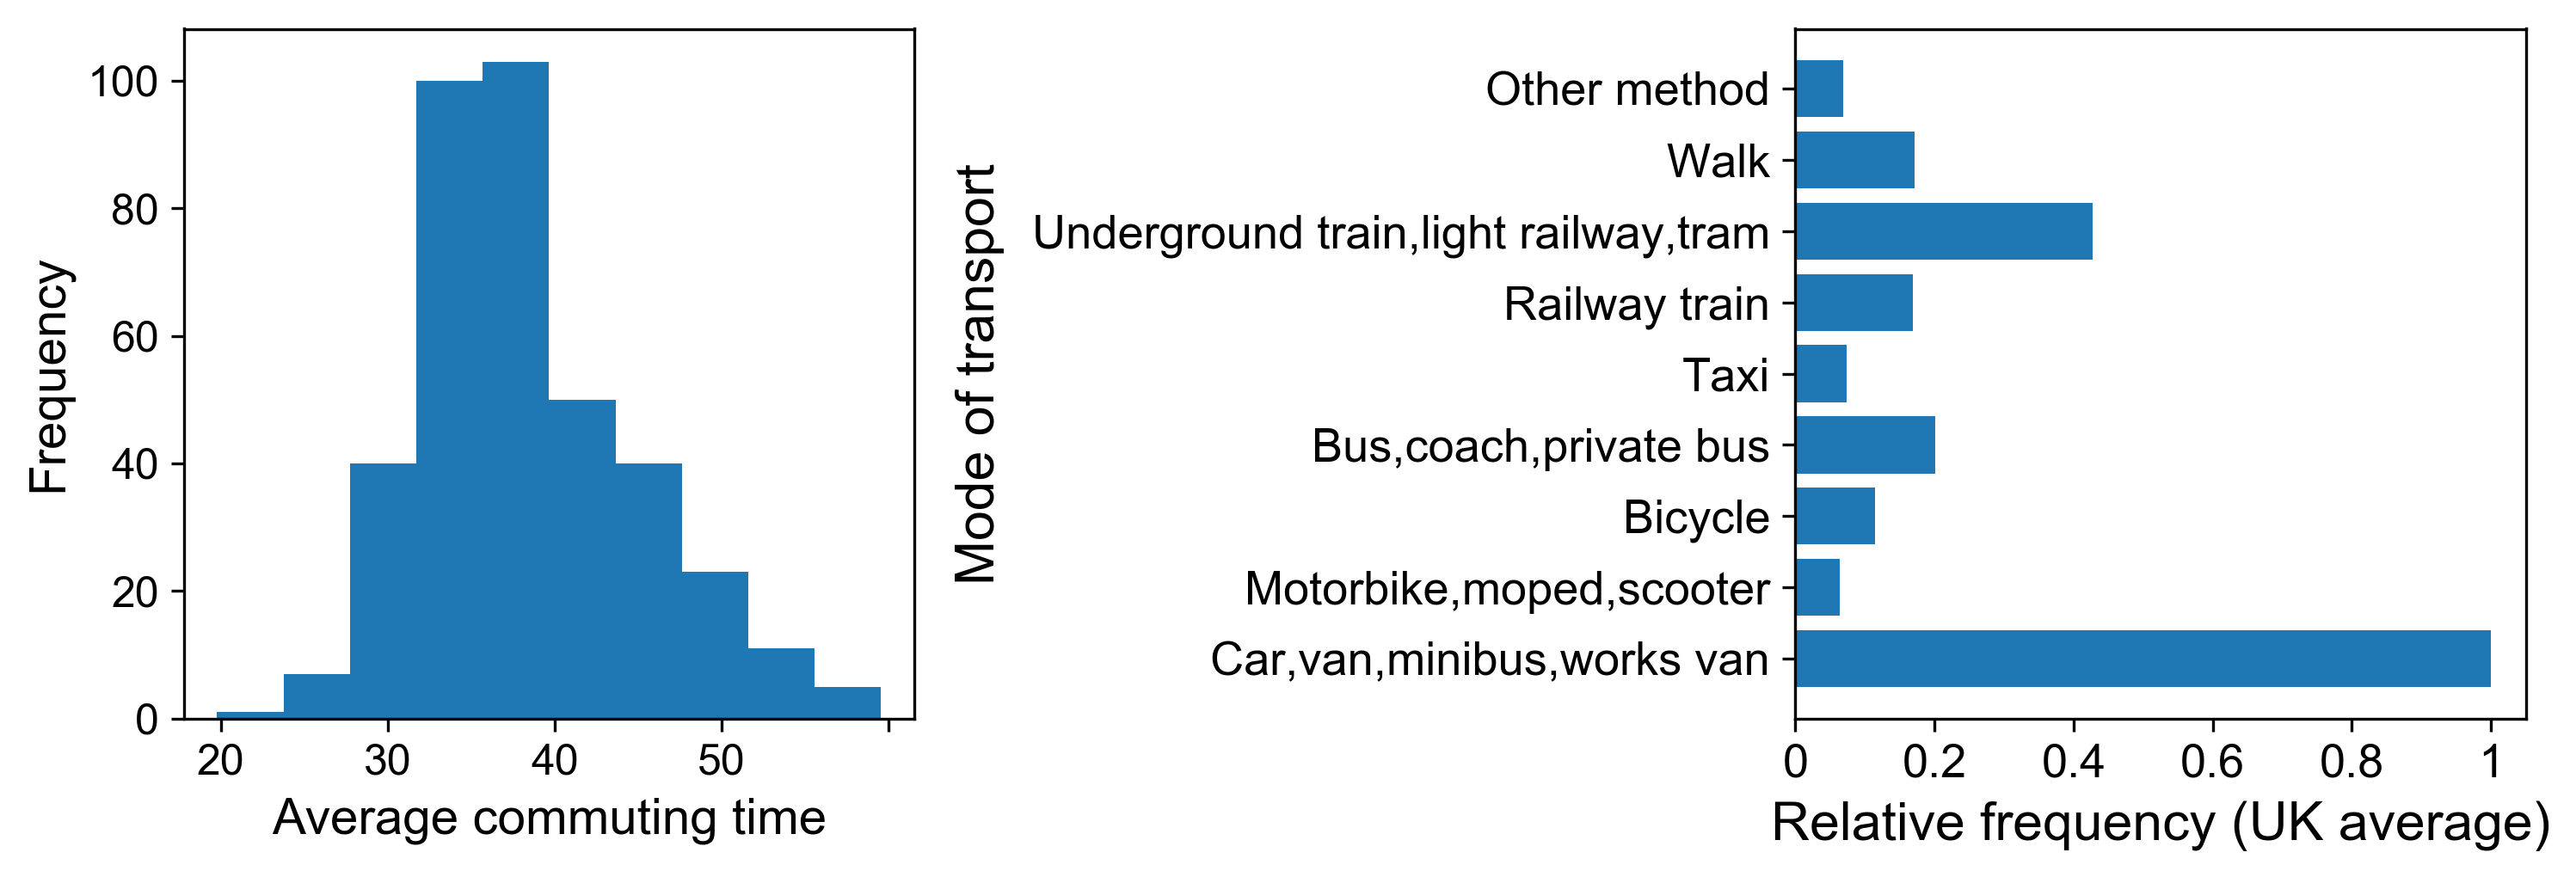

In [15]:
# load official statistics about average commuting times and modes of travel per local authority
def convert_string(x):
    try:
        return float(x)
    except:
        return np.nan
df_ons = pd.read_excel(avg_travel_times_ons, sheet_name='2016 clean')
print(df_ons.head(n=3))
all_ons_times = df_ons['Mean']
median_travel_times = all_ons_times.median()
fig, ax = plt.subplots(1,2, figsize = (10,3.5), dpi = 300)
ax[0].hist(all_ons_times) #.plot(kind= 'hist', ax = ax[0])
#plt.set_gca(ax[0])
ax[0].set_xlabel('Average commuting time', fontsize = 14)
ax[0].set_ylabel('Frequency', fontsize = 14)
#print(list(ax[0].get_yticklabels()))
ax[0].set_yticklabels([0,20,40,60,80,100], {'fontsize' : 12})
ax[0].set_xticklabels([10,20,30,40,50], fontsize = 12)
median_modes = {}
all_modes = [' Car,van,minibus,works van', ' Motorbike,moped,scooter',
       ' Bicycle', ' Bus,coach,private bus', 'Taxi', ' Railway train',
       ' Underground train,light railway,tram', ' Walk', ' Other method']
for col in all_modes:
    median_modes[col] = np.nanmean(np.array(df_ons[col].map(lambda x: convert_string(x)).values))
x = [t for t in median_modes.values()]
x = x/max(x)
ax[1].barh(range(1,10), x, tick_label = [t for t in median_modes.keys()])
#plt.gca().tick_params(rotation = 90)
plt.xlabel('Relative frequency (UK average)', fontsize = 15)
tmp = plt.ylabel('Mode of transport', fontsize = 15)
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), fontsize = 13)
plt.gca().set_xticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = 13)
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(plot_save_dir,'travel_times_mode_LA_ons_stats.png'), 
                bbox_inches = 'tight', dpi = 300)
    
    

In [16]:
# first, load the list of all TTWA
ttwa_data = pd.read_csv(ttwa_file)
# first column is ttwa codes, second column is ttwa names
ttwa_info11 = pd.read_excel(ttwa_info11_file)
ttwa_info16 = pd.read_excel(ttwa_info16_file)
#print(ttwa_info11.tail(n=3))
#print(ttwa_info16.tail(n=3))

# get small TTWAs
small_ttwas = list(ttwa_info11['ttwa11cd'][ttwa_info11['LSOAs']<40])
print('There are {} TTWAs with less than 40 LSOAs.'.format(len(small_ttwas)))

# now set the ttwa code as the index
ttwa_data = ttwa_data.set_index('ttwa11cd')
ttwa_info11 = ttwa_info11.set_index('ttwa11cd')
ttwa_info16 = ttwa_info16.set_index('ttwa11cd')

# drop rows
ttwa_data = ttwa_data.drop(small_ttwas, axis = 0)
ttwa_info11 = ttwa_info11.drop(small_ttwas, axis = 0)
ttwa_info16 = ttwa_info16.drop([t for t in small_ttwas if t in ttwa_info16.index], axis = 0)
ttwa_info16 = ttwa_info16.sort_index()
ttwa_info11 = ttwa_info11.sort_index()
#ttwa_data['Region/Country'] = ttwa_info16['Region/Country']

# Create aliases for the column names (need to be shorter to be plotted correctly)
rename_cols16 = {'Employment rate ': 'Employment rate',
       '% of economically inactive who want a job':'Job-seeking economically inactive',
       'Claimant Count, % aged 16-64, April 2015 to March 2016 ': 'Claimant count',
       'All in employment who are 1: managers, directors and senior officials (SOC2010)': 
                 'Employed in SOC code 1',
       ' All in employment who are 2: professional occupations or 3: associate prof & tech occupations (SOC2010)': 
                 'Employed in SOC code 2',
       'All in employment who are 5: skilled trades occupations (SOC2010)': 
                 'Employed in SOC code 5',
       'All in employment who are 6: caring, leisure and other service occupations (SOC2010)': 
                 'Employed in SOC code 6',
       'All in employment who are 8: process, plant and machine operatives (SOC2010)':
                 'Employed in SOC code 8',
       'All in employment who are 9: elementary occupations (SOC2010)':
                 'Employed in SOC code 9'}

rename_cols11 = {'Supply-side self-containment (% employed residents who work locally)':
                 'Supply-side self-containment',
       'Demand-side self-containment (% local jobs taken by local residents)':
                 'Demand-side self containment',
       'Number of economically active residents (aged 16+)':'Economically active residents'}
ttwa_info16.rename(rename_cols16, axis = 1, inplace = True)
ttwa_info11.rename(rename_cols11, axis = 1, inplace = True)

ttwa_data = ttwa_data.sort_index().join(ttwa_info11, rsuffix = '_2').join(ttwa_info16, 
                                                                            rsuffix = '_3')

ttwa_data = ttwa_data.reset_index()



There are 55 TTWAs with less than 40 LSOAs.


In [17]:
# load the extracted dictionaries of OA centroids
loadOA = True
loadLSOA = True
oa_path = ons_der_folder + 'oa_centroids_dictionary.pickle'
lsoa_path = ons_der_folder + 'lsoa_centroids_dictionary.pickle'
exists = os.path.isfile(oa_path)
if exists and loadOA:
    print('Loading the OA data')
    oa_data = pd.read_pickle(oa_path)
oa_data.rename(columns = {'long': 'lon'}, inplace = True)

exists = os.path.isfile(lsoa_path)
if exists and loadLSOA:
    print('Loading the LSOA data')
    lsoa_data = pd.read_pickle(lsoa_path)
lsoa_data.rename(columns = {'long': 'lon'}, inplace = True)

# Load the data dictionaries which then should be transformed to dataframes and joined.
# They should also be joined with the list of TTWAs for each OA
# Then, I can make the relevant plots
# What I want is a breakdown of mean travel distances for occupations and for ttwa

# first, load the data
with open(save_oa_file, 'rb') as f:
    _,oa_distances,oa_occupations,oa_residents,socGroups,_,_ = pickle.load(f)

with open(save_oa_file_jobs, 'rb') as f:
    _,oa_number_of_jobs,oa_jobs_breakdown,jobs_socGroups,_,_ = pickle.load(f)
    
print('Loaded LMIforALL data. Now joining')
t0 = time.time()
# join all dictionaries with oa_data and delete?
# first create the residents column and change the column title
oa_data = oa_data.join(pd.DataFrame.from_dict(oa_residents, orient = 'index'))
# now add everything else
oa_data.rename(columns = {0: 'residents'}, inplace = True)
oa_data = oa_data.join(
    pd.DataFrame.from_dict(oa_distances, orient = 'index')).join(
    pd.DataFrame.from_dict(oa_occupations, orient = 'index')).join(
    pd.DataFrame.from_dict(oa_number_of_jobs, orient = 'index')).join(
    pd.DataFrame.from_dict(oa_jobs_breakdown, orient = 'index'))
print('It took {:2f}s to create the full dataframe with {} rows'.format(time.time()- t0, 
                                                                        len(oa_data)))
# finally, rename the number of jobs column
oa_data.rename(columns = {0: 'number of jobs'}, inplace = True)
print(oa_data.head(n=2))

oa_occupations = None
oa_residents = None
oa_number_of_jobs = None
oa_jobs_breakdown = None
print('Done')

Loading the OA data
Loading the LSOA data
Loaded LMIforALL data. Now joining
It took 154.568130s to create the full dataframe with 232034 rows
                 lat       lon       ttwa     lsoa11  residents  \
oa11                                                              
E00000001  51.520345 -0.094809  E30000234  E01000001      102.0   
E00000003  51.519846 -0.096589  E30000234  E01000001      147.0   

           Mean distance to work (overall)      code  \
oa11                                                   
E00000001                         4.902913  dist2549   
E00000003                         5.510204  dist2549   

           Mean distance to work (males)  Mean distance to work (females)  \
oa11                                                                        
E00000001                            4.5                         5.465116   
E00000003                            5.0                         6.171875   

           Mean distance to work (ages 16-24)  ...  24

### Select UK region of interest

In [19]:
# set the region to use
region2use = 'wm'
region_name = 'West Midlands'
if TRANSPORT:
    # set up propeR
    # open the connection to Open Trip Planner
    otpcon = propeR.otpConnect(router = 'default_{}'.format(region2use))

    # [TODO] how to check the connection is open?


In [20]:
# get all the TTWA in the region
regional_ttwa = ttwa_data[ttwa_data['Region/Country'] == region_name][['ttwa11cd','ttwa11nm','LSOAs']]
# collect the TTWA names
ttwa_formal_names = {}
for t in regional_ttwa.index:
    ttwa_formal_names[t] = regional_ttwa['ttwa11nm'].loc[t]
print(regional_ttwa)

      ttwa11cd                     ttwa11nm  LSOAs
23   E30000169                   Birmingham   1039
45   E30000195                     Coventry    367
51   E30000202                       Dudley    338
63   E30000216                     Hereford    100
72   E30000228               Leamington Spa    151
101  E30000262                   Shrewsbury     94
107  E30000271                     Stafford     95
109  E30000273               Stoke-on-Trent    336
114  E30000278                      Telford    138
123  E30000288    Wolverhampton and Walsall    466
124  E30000289  Worcester and Kidderminster    198


In [21]:
# load the LSOA names files
lsoa_names_file = data_folder + 'ONS/Lower_Layer_Super_Output_Areas_December_2011_Names_and_Codes_in_England_and_Wales.csv'
lsoa_names = pd.read_csv(lsoa_names_file)
lsoa_names = lsoa_names.set_index('LSOA11CD')

### Coversion from TTWA to LAD and viceversa

In [22]:
# try to match upper tier local authority to TTWA through LSOAs
groups = lsoa_data.groupby('ttwa')
ttwa_to_utlas = {}
all_utlas = []
for jj,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    ttwa_name = regional_ttwa['ttwa11nm'].loc[ttwa]
    # get the group corresponding to this TTWA
    group = groups.get_group(ttwa_code)
    utlas = []
    ttwa_to_utlas[ttwa_name] = []
    for lsoa in group.index:
        ttwa_to_utlas[ttwa_name].append(lsoa_to_lad['LAD17NM'][lsoa_to_lad['LSOA11CD']==lsoa].values[0])
    all_utlas = all_utlas + list(set(ttwa_to_utlas[ttwa_name]))
ttwa_utlas = {}
for jj,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11nm'].loc[ttwa]
    ttwa_name = regional_ttwa['ttwa11nm'].loc[ttwa]
    ttwa_utlas[ttwa_name] = {}
    for utla in all_utlas:
        ttwa_utlas[ttwa_name][utla] = np.sum([t == utla for t in ttwa_to_utlas[ttwa_name]])
print(pd.DataFrame.from_dict(ttwa_utlas,orient = 'index').columns)

Index(['Solihull', 'Redditch', 'Sandwell', 'Walsall', 'North Warwickshire',
       'Lichfield', 'Wychavon', 'Bromsgrove', 'Birmingham',
       'Stratford-on-Avon', 'Tamworth', 'Coventry', 'Warwick',
       'Hinckley and Bosworth', 'Rugby', 'Daventry', 'Nuneaton and Bedworth',
       'Wyre Forest', 'Dudley', 'South Staffordshire',
       'Herefordshire, County of', 'Cotswold', 'Shropshire', 'Cannock Chase',
       'Stafford', 'Stoke-on-Trent', 'East Staffordshire',
       'Staffordshire Moorlands', 'Cheshire East', 'Newcastle-under-Lyme',
       'Telford and Wrekin', 'Wolverhampton', 'Malvern Hills', 'Worcester'],
      dtype='object')


In [23]:
# create the dataframe
tmp = pd.DataFrame.from_dict(ttwa_utlas,orient = 'index')#, columns = la_columns)
# only keep those LAD that overlap with at least 10 LSOAs in total with all the TTWAs
tmp = tmp[tmp.columns[tmp.sum()>10]]
la_columns = tmp.columns #['Walsall',  'Worcestershire',  
#            'Sandwell',  'Birmingham', 'Solihull','Staffordshire',
#           'Warwickshire','Coventry', 'Dudley', 'Herefordshire, County of', 
#          'Shropshire',  'Stoke-on-Trent', 'Telford and Wrekin',  'Wolverhampton']
ttwa_to_la = {}
la_to_ttwa = {}
for la in la_columns:
    # just one exception
    if la == 'Staffordshire':
        print('exception')
        la_to_ttwa[la] = 'Stafford'
    else:
        # match the local authority to the TTWA with the most overlap
        # (i.e. that contains most of the LSOAs in that LA)
        la_to_ttwa[la] = tmp[tmp[la] == tmp[la].max()].index[0]
    # now add the LA to the list of LAs in that TTWA
    if la_to_ttwa[la] in ttwa_to_la.keys():
        ttwa_to_la[la_to_ttwa[la]] += [la]
    else:
        ttwa_to_la[la_to_ttwa[la]] = [la]
    
print(ttwa_to_la, la_to_ttwa)

{'Birmingham': ['Solihull', 'Redditch', 'North Warwickshire', 'Bromsgrove', 'Birmingham', 'Tamworth'], 'Dudley': ['Sandwell', 'Dudley'], 'Wolverhampton and Walsall': ['Walsall', 'Lichfield', 'South Staffordshire', 'Cannock Chase', 'Wolverhampton'], 'Worcester and Kidderminster': ['Wychavon', 'Wyre Forest', 'Malvern Hills', 'Worcester'], 'Leamington Spa': ['Stratford-on-Avon', 'Warwick'], 'Coventry': ['Coventry', 'Rugby', 'Nuneaton and Bedworth'], 'Hereford': ['Herefordshire, County of'], 'Shrewsbury': ['Shropshire'], 'Stafford': ['Stafford'], 'Stoke-on-Trent': ['Stoke-on-Trent', 'East Staffordshire', 'Staffordshire Moorlands', 'Cheshire East', 'Newcastle-under-Lyme'], 'Telford': ['Telford and Wrekin']} {'Solihull': 'Birmingham', 'Redditch': 'Birmingham', 'Sandwell': 'Dudley', 'Walsall': 'Wolverhampton and Walsall', 'North Warwickshire': 'Birmingham', 'Lichfield': 'Wolverhampton and Walsall', 'Wychavon': 'Worcester and Kidderminster', 'Bromsgrove': 'Birmingham', 'Birmingham': 'Birmingha

In [30]:
# now assign average commuting times from ONS to each TTWA
#print(list(df_ons['Unnamed: 0']))
avg_ons_times = {}
for ttwa in ttwa_to_la.keys():
    tmp = 0
    ttwa_code = list(regional_ttwa[regional_ttwa['ttwa11nm']==ttwa]['ttwa11cd'].values)[0]
    # cycle through the local authorities in the ONS dataset. They're in the form code + name.
    divider = 0
    for k,lacd in enumerate(df_ons['Unnamed: 0']):
        # Look for the ones with the right name, 
        # ttwa_to_la[ttwa] gives the list of local authorities in this TTWA
        tmp2 = [t in lacd for t in ttwa_to_la[ttwa]]
        if any(tmp2):
            #print(lacd,k,ttwa,ttwa_to_la[ttwa])
            # add the average commuting time in that LA
            tmp += df_ons['Mean'].iloc[k]
            divider += 1 
            # now divide by the # of LAs
    tmp = tmp / divider #len(ttwa_to_la[ttwa])
    avg_ons_times[ttwa_code] = tmp
print(avg_ons_times)

{'E30000169': 27.74348216925966, 'E30000202': 26.182364641362433, 'E30000288': 26.10575987160262, 'E30000289': 24.04132435741679, 'E30000228': 26.08123934206029, 'E30000195': 25.506351020493863, 'E30000216': 25.60484408942408, 'E30000262': 20.215006933005768, 'E30000271': 23.5930759814085, 'E30000273': 23.224063902548732, 'E30000278': 18.949458634092174}


In [31]:
# first, get the distance in miles, using geopy
flying_crow = {}
for t,ttwa in enumerate(regional_ttwa.index):
    t0 = time.time()
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    all_lsoas = list(lsoa_data[lsoa_data['ttwa']==ttwa_code].index)
    flying_crow[ttwa_code] = np.zeros((len(all_lsoas),len(all_lsoas)))
    for to, origin_lsoa in enumerate(all_lsoas):
        for td, destination_lsoa in enumerate(all_lsoas):
            coords_1 = (lsoa_data['lat'].loc[origin_lsoa],lsoa_data['lon'].loc[origin_lsoa])
            coords_2 = (lsoa_data['lat'].loc[destination_lsoa],lsoa_data['lon'].loc[destination_lsoa])
            flying_crow[ttwa_code][to,td] = geodesic(coords_1, coords_2).miles
    print_elapsed(t0, 'computing distances for {}'.format(regional_ttwa['ttwa11nm'].loc[ttwa]))


Time spent on computing distances for Birmingham is 337.638s
Time spent on computing distances for Coventry is 41.303s
Time spent on computing distances for Dudley is 37.963s
Time spent on computing distances for Hereford is 3.149s
Time spent on computing distances for Leamington Spa is 8.489s
Time spent on computing distances for Shrewsbury is 3.596s
Time spent on computing distances for Stafford is 3.087s
Time spent on computing distances for Stoke-on-Trent is 38.227s
Time spent on computing distances for Telford is 5.755s
Time spent on computing distances for Wolverhampton and Walsall is 67.106s
Time spent on computing distances for Worcester and Kidderminster is 11.787s


In [32]:
# get number of jobs in each LSOA
local_lsoas_number_of_jobs = {}
for t,ttwa in enumerate(regional_ttwa.index):
    local_lsoas_number_of_jobs[ttwa] = []
    t0 = time.time()
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    local_lsoa = lsoa_data[lsoa_data['ttwa']==ttwa_code]
    for lsoa in local_lsoa.index:
        oa_list = local_lsoa['oa_list'].loc[lsoa]
        tot_lsoa_jobs = []
        for oa in oa_list:
            tot_lsoa_jobs.append(oa_data['number of jobs'].loc[oa])
        # add the absolute number of jobs
        local_lsoas_number_of_jobs[ttwa].append(sum(tot_lsoa_jobs))
        #local_lsoa_density_of_jobs.append(np.mean(tot_lsoa_jobs))
        #local_lsoa_max_of_jobs.append(max(tot_lsoa_jobs))
    # turn the list into a series
    local_lsoas_number_of_jobs[ttwa] = pd.DataFrame(local_lsoas_number_of_jobs[ttwa], columns = ['number of jobs'], 
                                                   index= local_lsoa.index)

In [33]:
# get the occupations breakdown per LSOA in terms of number of jobs
values_cols = []
cols_by_digits = {}
for col in oa_data.columns:
    if ('value' in col) & (len(col)==9):
        # the condition on the length is to eliminate the columns that are about the breakdown by occupations
        # for residents, we only want the breakdown by occupations for workers
        values_cols.append(col)
        digit = col[0]
        if digit in cols_by_digits:
            cols_by_digits[digit].append(col)
        else:
            cols_by_digits[digit] = [col]
# first, select TTWAs of interest
oa_data['regional'] = oa_data['ttwa'].map(lambda x: x in list(regional_ttwa['ttwa11cd'].values))
# for selected TTWAs, group by LSOA and sum the number of workers in each occupation
oa_groups = oa_data[oa_data['regional']].groupby(by = 'lsoa11')[values_cols].agg(np.sum)
# add the TTWA each LSOA belongs to
oa_groups = oa_groups.join(oa_data[oa_data['regional']].groupby(by = 'lsoa11')['ttwa'].agg(pd.unique))
# now sum all workers with the same first digit
for digit in cols_by_digits.keys():
    oa_groups[digit + '_value'] = oa_groups[cols_by_digits[digit]].sum(axis = 1)
print(oa_groups.head(n=3))

           350_value  213_value  354_value  125_value  113_value  341_value  \
lsoa11                                                                        
E01008881       70.0       12.0       20.0       45.0       12.0       10.0   
E01008882       59.0       25.0       25.0       38.0       22.0        6.0   
E01008883       81.0       15.0       46.0       23.0       26.0       16.0   

           711_value  119_value  421_value  927_value  ...       ttwa  \
lsoa11                                                 ...              
E01008881      142.0       36.0       36.0       50.0  ...  E30000169   
E01008882      116.0       23.0       46.0       33.0  ...  E30000169   
E01008883       54.0       29.0       46.0       16.0  ...  E30000169   

           3_value  2_value  1_value  7_value  4_value  9_value  5_value  \
lsoa11                                                                     
E01008881    228.0    297.0    141.0    183.0    208.0    152.0    271.0   
E01008882 

In [25]:
# load the data already collected for this region and organise it into a better format
LOAD_JOINED = True
modes = 'CAR'
lmodes = modes.lower().replace(' ','').replace(',','')

if LOAD_JOINED:
    # load the already joined data
    with open(os.path.join(tmp_proper_results,'all_data_for_{}_and_{}.pickle'.format(
        region_name.replace(' ',''),modes.lower())), 'rb') as f:
        all_durations, all_distances, origin_lsoas_coord, dest_lsoas_coord, origin_lsoas_names, dest_lsoas_names, origin_lsoas, dest_lsoas = pickle.load(f)
else:
    # load each separate file, then save it
    # initialise dictionaries of matrices
    all_durations = {} # this contains all the duration matrices
    all_distances = {}
    origin_lsoas_coord = {}
    dest_lsoas_coord = {}
    origin_lsoas_names = {}
    dest_lsoas_names = {}
    origin_lsoas = {}
    dest_lsoas = {}
    for t,ttwa in enumerate(regional_ttwa.index):
        t0 = time.time()
        ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
        local_lsoa = lsoa_data[lsoa_data['ttwa']==ttwa_code].join(local_lsoas_number_of_jobs[ttwa]).sort_values(
            'number of jobs', ascending = False)
        all_lsoas = list(local_lsoa.index)
        all_durations[ttwa_code] = np.zeros((20,len(all_lsoas)))
        all_distances[ttwa_code] = np.zeros((20,len(all_lsoas)))
        for to, origin_lsoa in enumerate(all_lsoas):
            # only compute travel times for the top 20 destinations
            for td, destination_lsoa in enumerate(all_lsoas[:20]):

                # set the name for the folder where the output was saved, since I can't control
                # the name with which the output is stored
                directoryID = os.path.join(tmp_proper_results,
                                           'ttwa{}_{}/o{}_d{}_{}'.format(ttwa_code,modes.replace(',','').replace(' ',''), 
                                                                  origin_lsoa,
                                                                  destination_lsoa,modes.replace(',','').replace(' ','')))
                if  os.path.exists(directoryID):
                    content = os.listdir(directoryID)
                    # there should be only one .csv file: select it
                    content = [t for t in content if t.endswith('.csv')]
                    if len(content) != 1:
                        print('Houston, we have a problem. ')
                        print(directoryID)
                        stop
                    # load the csv data
                    df = pd.read_csv(os.path.join(directoryID, content[0]))
                    # combine the data from all pairs of origin and destination OAs
                    distances = np.array(df['distance_km'].values)
                    durations = np.array(df['duration_mins'].values)
                    # filter out any NaNs
                    distances = distances[~np.isnan(durations)]
                    durations = durations[~np.isnan(durations)]
                    # take the average
                    if len(distances):
                        all_distances[ttwa_code][td,to] = np.mean(distances)
                        all_durations[ttwa_code][td,to] = np.mean(durations)
                    else:
                        all_distances[ttwa_code][td,to] = np.nan
                        all_durations[ttwa_code][td,to] = np.nan
                else:
                    # somehow this data wasn't collected!
                    print('Some data was not collected. Problems arose for: ')
                    print(directoryID, origin_lsoa, destination_lsoa, ttwa_code)
                    #stop
                    # set these data as NaN?
                    continue
                # also, collect the coordinates
                origin_lsoas_coord[ttwa_code] = [(local_lsoa['lon'].loc[t],local_lsoa['lat'].loc[t]) 
                                                 for t in all_lsoas]
                dest_lsoas_coord[ttwa_code] = [(local_lsoa['lon'].loc[t],local_lsoa['lat'].loc[t]) 
                                               for t in all_lsoas[:20]]
                # turn codes into names
                origin_lsoas_names[ttwa_code] = lsoa_names['LSOA11NM'].loc[all_lsoas].values
                dest_lsoas_names[ttwa_code] = lsoa_names['LSOA11NM'].loc[all_lsoas[:20]].values
                origin_lsoas[ttwa_code] = all_lsoas
                dest_lsoas[ttwa_code] = all_lsoas[:20]
            #print_elapsed(t0, 'getting the data for LSOA {} of TTWA {}'.format(origin_lsoa,ttwa_code))
        print_elapsed(t0, 'getting the data for TTWA {}'.format(ttwa_code))

    # save the data as one pickle files, so it doesn't need to be downloaded again
    with open(os.path.join(tmp_proper_results,'all_data_for_{}_and_{}.pickle'.format(
        region_name.replace(' ',''),modes.lower())), 'wb') as f:
        pickle.dump((all_durations, all_distances, origin_lsoas_coord, dest_lsoas_coord, 
                     origin_lsoas_names, dest_lsoas_names, origin_lsoas, dest_lsoas),f)

In [52]:
'''
Functions for plotting (individual TTWAs)
'''
def plot_durations_heatmap(duration_matrix, Th, origin_lsoas_labels, dest_lsoas_labels, 
                           ttwa_name, mode, plot_save_dir ='', SAVEFIG = False, which_api = 'OTP'):
    '''
    # heatmap of thresholded durations for one TTWA
    '''
    with sns.axes_style('white'):
        with sns.plotting_context('paper', font_scale = 1.3):
            fig, ax = plt.subplots(figsize=(23,6))
            g = sns.heatmap(duration_matrix, xticklabels=origin_lsoas_labels, 
                            yticklabels=dest_lsoas_labels, 
                        mask= (duration_matrix > Th) | (duration_matrix==0), 
                        square = False, vmax = Th,
                           cbar_kws={'label':'Average commuting time for {} journeys'.format(mode)})
            plt.xlabel('Origins, where people live ({})'.format(ttwa_name), fontsize = 20)
            plt.ylabel('Destinations. where jobs are ({})'.format(ttwa_name), fontsize = 20)
            plt.gca().set_yticklabels(plt.gca().get_yticklabels(), fontsize = 14)
            plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize = 12)
            cax = plt.gcf().axes[-1]
            cax.tick_params(labelsize=14)
            plt.tight_layout()
    if SAVEFIG:
        plt.savefig(os.path.join(plot_save_dir,'thresholded_commute_time_matrix_{}_{}_{}.png'.format(
            ttwa_name,mode,which_api)), bbox_inches = 'tight', dpi = 300)
    plt.draw()

# histograms     
def plot_population_hist(population_vector, ttwa_formal_name, plot_save_dir ='', SAVEFIG = False):
    with sns.plotting_context('talk'):
        fig = plt.figure(figsize = (6,4))
        sns.distplot(population_vector, axlabel = 'Population in a given LSOA in {}'.format(ttwa_formal_name))
    tmp = plt.ylabel('LSOA density')
    if SAVEFIG:
        plt.savefig(os.path.join(plot_save_dir,'population_by_LSOA_{}.png'.format(ttwa_formal_name)), 
                    bbox_inches = 'tight', dpi = 300)
    plt.draw()

def plot_jobs_hist(vector, ttwa_formal_name, plot_save_dir ='', 
                   SAVEFIG = False, t_rotation = 45, nbins = 10):
    # this is to plot a count histogram with no overlap estimated pdf (used for jobs vector and Ajt)
    with sns.plotting_context('talk'):
        fig = plt.figure(figsize = (6,4))
        tmp = sns.distplot(vector, axlabel = 'Number of jobs in a given LSOA in {}'.format(ttwa_formal_name), 
                           bins = nbins, norm_hist = False, kde = False)
    plt.xticks(rotation = t_rotation)
    tmp = plt.ylabel('LSOA count')
    if SAVEFIG:
        plt.savefig(os.path.join(plot_save_dir, 'jobs_by_destination_LSOA_{}.png'.format(ttwa_formal_name)), 
                    bbox_inches = 'tight', dpi = 300)
    plt.draw()

def plot_dest_accessibility_hist(vector, ttwa_formal_name, mode, plot_save_dir ='', 
                   SAVEFIG = False, t_rotation = 45, nbins = 5, which_api = 'OTP'):
    # this is to plot a count histogram with no overlap estimated pdf (used for jobs vector and Ajt)
    with sns.plotting_context('talk'):
        fig = plt.figure(figsize = (6,4))
        tmp = sns.distplot(vector, bins = nbins, norm_hist = False, kde = False,
                           axlabel = 'Percentage of people less than 45 minutes away ({})'.format(ttwa_formal_name))
    plt.xticks(rotation = t_rotation)
    tmp = plt.ylabel('LSOA count')
    if SAVEFIG:
        plt.savefig(os.path.join(plot_save_dir, 'ease_of_commute_distribution_{}_{}_{}.png'.format(
            ttwa_formal_name,mode,which_api)), bbox_inches = 'tight', dpi = 300)
    plt.draw()

def plot_feasible_edges(xs,ys,order,origin_lsoas,origin_lsoas_coord, durations_matrix):
    # first, reshape the bounding box coordinates
    xs = np.reshape(np.array(xs),(-1,2))
    ys = np.reshape(np.array(ys),(-1,2))
    N = 20
    # collect the centers from the map data
    tmp = [(np.mean(xs[t]),np.mean(ys[t])) for t in range(xs.shape[0])]
    centers = []
    for lsoa in origin_lsoas:
        ix = order.index(lsoa)
        centers.append(tmp[ix])
    # transform into array
    centers_array = np.array(centers)
    coords_array = np.array(origin_lsoas_coord)
    # remove the mean
    centers_array = centers_array - np.mean(centers_array, axis= 0, keepdims = True)
    centers_array = centers_array / np.max(centers_array, axis = 0)
    coords_array = coords_array - np.mean(coords_array, axis= 0, keepdims = True)
    coords_array = coords_array / np.max(coords_array, axis = 0)
    fig = plt.figure(figsize = (15,15))
    Nx, Ny = durations_matrix.shape
    for ix in range(Nx):
        for iy in range(ix+1,Ny):
            if durations_matrix[ix,iy]<45:
                plt.plot([coords_array[ix,0],coords_array[iy,0]],[coords_array[ix,1],coords_array[iy,1]],
                         'k',alpha = 0.6)
    plt.plot(coords_array[:,0],coords_array[:,1],'o')
    tmp = plt.plot(coords_array[:N,0],coords_array[:N,1],'o')
    plt.draw()

def plot_commute_curve(EofC2_vector, ms, ttwa_name, mode, plot_save_dir = '', SAVEFIG = False, which_api = 'OTP'):
    # plot EofC2 vs m
    with sns.plotting_context("talk"):
        fig, ax = plt.subplots(figsize=(7,4))
        sns.lineplot(x = ms*100, y = EofC2_vector*100, color='k', marker = 'o')
        sns.lineplot(x = ms*100, y =100 + np.zeros_like(ms), color = [1, 90/255, 0])
        plt.xlabel('Population threshold (%)')
        plt.ylabel('Percentage of accessible jobs')
        plt.title('TTWA: {}'.format(ttwa_name))
        plt.legend(('Actual curve','Ideal curve'), fontsize= 16, frameon = False)
        # think about the interpretation again +  check R + 
    if SAVEFIG:
        plt.savefig(os.path.join(plot_save_dir,'ease_of_commute_score2_distribution_{}_{}_{}.png'.format(
            ttwa_name,mode,which_api)), bbox_inches = 'tight', dpi = 300)
    plt.draw()

def plot_commute_curve_check(Ajt, jobs_vector_norm, EofC2_vector, ttwa_name, mode,
                            plot_save_dir = '', SAVEFIG = False, which_api = 'OTP'):
    # only use function to show the rationale behind the commuting curve
    # basically, this is only kept for legacy reasons
    base = np.sort(Ajt)
    ix_sort = np.argsort(Ajt)
    jobs_vector_sorted = jobs_vector_norm[ix_sort]
    cumulative = np.arange(1,len(Ajt)+1)/len(Ajt)
    cumulative2 = np.cumsum(jobs_vector_sorted)
    cumulative2 = cumulative2/np.max(cumulative2)
    with sns.plotting_context('talk'):
        plt.figure(figsize = (7,4))
        plt.plot(base*100,cumulative, marker = 'o')
        plt.plot(ms*100, 1- EofC2_vector, marker = 'o')
        plt.plot(base*100,cumulative2, '--o', markersize = 7)
        plt.legend(['ecdf','1 - EofC2','weighted ecdf'])
        plt.xlabel('Population threshold (%)')
        plt.ylabel('Probability')
        plt.title('TTWA: {}'.format(ttwa_name))
    if SAVEFIG:
        plt.savefig(os.path.join(plot_save_dir,'ease_of_commute_score2_interpretation_{}_{}_{}.png'.format(
            ttwa_name, mode, which_api)), bbox_inches = 'tight', dpi = 300)
    plt.draw()

'''
Functions for computing measures (individual TTWAs). For definitions refer to the google doc
'''

def compute_jobs_and_population(origin_lsoas, lsoa_data, oa_data, 
                                dest_lsoas, local_lsoa_number_of_jobs):
    # TODO: this function might need to be reviewed!!
    # assign and multiply by how many people are in each LSOA
    population_vector = np.zeros((len(origin_lsoas)))
    for ix,lsoa in enumerate(origin_lsoas):
        for oa in lsoa_data['oa_list'].loc[lsoa]:
            population_vector[ix] += oa_data['residents'].loc[oa]
    # normalise so that it sums to 1
    population_vector_norm = population_vector / np.sum(population_vector)

    # load how many jobs there are in each LSOA
    N = len(dest_lsoas)
    jobs_vector = np.array(local_lsoa_number_of_jobs['number of jobs'].values)[:N]
    #jobs_vector = np.zeros((len(dest_lsoas)))
    #for ix,lsoa in enumerate(dest_lsoas):
    #    for oa in lsoa_data['oa_list'].loc[lsoa]:
    #        jobs_vector[ix] += local_oa_number_of_jobs[oa]
    # normalise so that it sums to 1
    jobs_vector_norm = jobs_vector / np.sum(jobs_vector)
    return population_vector, population_vector_norm, jobs_vector, jobs_vector_norm

# compute cumulative accessibility measures
def get_cumulative_accessibility_measures(durations_matrix, Th, 
                            jobs_vector_norm, population_vector_norm, origin_lsoas, dest_lsoas):
    # for each origin LSOA, compute how many jobs can be reached within the threshold
    Bit = np.sum((durations_matrix<Th) * jobs_vector_norm[:,np.newaxis], axis = 0)*100
    # add it to a dataframe
    Bit_df = pd.DataFrame(Bit, columns = ['jobs percentage'])
    # add the LSOA code to the dataframe
    Bit_df = Bit_df.join(pd.DataFrame(origin_lsoas , columns =['lsoacd']))
    # for each destination LSOA compute the sum of residents that can reach it within 45 minutes
    # note that the expression below is equivalent to np.dot(dur<Th, pop_vector_norm)
    Ajt = np.sum(population_vector_norm * (durations_matrix < Th), axis = 1)
    # now compute the same vector but weighted by the number of jobs at destination
    Wjt = Ajt * jobs_vector_norm
    # together with the expression above, EofC1 = np.dot(jobs, np.dot(dur<Th, population))
    EofC1 = np.sum(Wjt)
    # compute other aggregated quantities
    # ease of commute 1 normalised
    EofC1min = np.sum(population_vector_norm[:len(dest_lsoas)] * jobs_vector_norm)
    EofC1norm = 1/(1-EofC1min) * (EofC1 - EofC1min)
    # ease of commute 2
    m = 0.5
    EofC2 = np.sum(jobs_vector_norm * ((Ajt - m)>0))
    # ease of commute graph
    base = np.sort(Ajt)
    ix_sort = np.argsort(Ajt)
    jobs_vector_sorted = jobs_vector_norm[ix_sort]
    cumulative = np.arange(1,len(Ajt)+1)/len(Ajt)
    cumulative2 = np.cumsum(jobs_vector_sorted)
    cumulative2 = cumulative2/np.max(cumulative2)
    # compute the EofC2 vector for relevant threshold values
    ms = np.array([0] + [base[0]-0.001] + [t +.001 for t in list(base[0:-1])] + [base[-1]-.001] + [
        base[-1]+.001]+ [1])
    EofC2_vector = np.sum(jobs_vector_norm[:,np.newaxis] * (np.subtract.outer(Ajt,ms) > 0), axis = 0)
    return Bit, Bit_df, Ajt, Wjt, EofC1, EofC1min, EofC1norm, m, EofC2, ms, EofC2_vector

# print some relevant information
def print_scores_to_file(plot_save_dir, ttwa_formal_name, EofC1, EofC1norm, EofC2, EofC2_vector, m, ms):
    with open(os.path.join(plot_save_dir,'out_{}.txt'.format(ttwa_formal_name)), 'w') as f:
        print('Overall, {} has an ease of commute score nb. 1 of {:.3f}'.format(ttwa_formal_name,EofC1), file= f)
        # the following assumes that the origin LSOAs are ordered so that the first D of them are the destinations
        print('Overall, {} has a normalised ease of commute score nb. 1 of {:.3f}'.format(ttwa_formal_name,
                                                                            EofC1norm),file= f)
        print('Overall, {} has an ease of commute score nb. 2 of {:.1f}%. That is, '.format(
            ttwa_formal_name,EofC2*100) + 
            'this is the percentage of jobs that can be reached by at least {:.0f}% of the population '.format(
                100*m)+ 
            'within the time constraint', file= f)
    # Note: the last sentence means that for each of the jobs in that 58.5% I can find a subset of LSOAs from which
    # it can be reached within 45 minutes that together account for at least 50% of the population
    # Saying that no job can be reached by 80% of the population means that there is no specified job that can be
    # reached by 80% of the population in less than 45 minutes.
    # get the maximum percentage of population that can access all jobs within the threshold:
    max_pop = ms[np.where(EofC2_vector>0.99999)[0][-1]]
    # print the minimum population percentage for which the percentage of accessible jobs is lower than 50%:
    min_pop = ms[np.where(EofC2_vector<0.5)[0][0]]
    with open(os.path.join(plot_save_dir, 'out_{}.txt'.format(ttwa_formal_name)) , 'a') as f:
        print('The maximum percentage of population that can access all jobs within the threshold is {:.2f}%'.format(
            max_pop*100), file= f)
        print('The minimum population percentage for which the percentage of accessible jobs is lower than 50% ' + 
              'is {:.2f}%'.format(min_pop*100), file= f)
    
def print_scores(ttwa_formal_name, EofC1, EofC1norm, EofC2, EofC2_vector, m, ms):
    # print again here
    print('Overall, {} has an ease of commute score nb. 1 of {:.3f}'.format(ttwa_formal_name,EofC1))
    print('Overall, {} has a normalised ease of commute score nb. 1 of {:.3f}'.format(ttwa_formal_name,EofC1norm))
    print('Overall, {} has an ease of commute score nb. 2 of {:.1f}%. That is, '.format(ttwa_formal_name,EofC2*100)+ 
          'this is the percentage of jobs that can be reached by at least {:.0f}% of the population '.format(100*m)+ 
          'within the time constraint')
    
    # get the maximum percentage of population that can access all jobs within the threshold:
    max_pop = ms[np.where(EofC2_vector>0.99999)[0][-1]]
    # print the minimum population percentage for which the percentage of accessible jobs is lower than 50%:
    min_pop = ms[np.where(EofC2_vector<0.5)[0][0]]
    print('The maximum percentage of population that can access all jobs within the threshold is {:.2f}%'.format(
        max_pop*100))
    print('The minimum population percentage for which the percentage of accessible jobs is lower than 50% ' + 
          'is {:.2f}%'.format(min_pop*100))
    
    

In [28]:
# set the threshold
Th = {'CAR': 1, 'WALK, TRANSIT': 2}[modes] * median_travel_times



In [34]:
'''
For each TTWA in WM I have the following info arranged in dictionaries
with the ttwa codes as keys:
(all_durations, all_distances, origin_lsoas_coord, dest_lsoas_coord, 
origin_lsoas_names, dest_lsoas_names, origin_lsoas, dest_lsoas)
I also have local_lsoas_number_of_jobs but the key is the index from the regional_ttwa dataframe
'''
commute_measures = {}
for t,ttwa in enumerate(regional_ttwa.index):
    t0 = time.time()
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    local_lsoa = lsoa_data[lsoa_data['ttwa']==ttwa_code].join(local_lsoas_number_of_jobs[ttwa]).sort_values(
            'number of jobs', ascending = False)
    # first compute all the quantities:
    # population and jobs vectors
    population_vector, population_vector_norm, jobs_vector, jobs_vector_norm = compute_jobs_and_population(
                                origin_lsoas[ttwa_code], lsoa_data, oa_data, dest_lsoas[ttwa_code], 
                                local_lsoas_number_of_jobs[ttwa])
    # jobs accessibility measures
    Bit,Bit_df,Ajt,Wjt,EofC1,EofC1min,EofC1norm, m, EofC2, ms, EofC2_vector = get_cumulative_accessibility_measures(
                            all_durations[ttwa_code], Th, jobs_vector_norm, 
                            population_vector_norm, origin_lsoas[ttwa_code], dest_lsoas[ttwa_code])
    
    commute_measures[ttwa_code] = {}
    commute_measures[ttwa_code]['name'] = ttwa_formal_names[ttwa]
    # store the quantities
    for var in ['population_vector', 'population_vector_norm', 'jobs_vector', 'jobs_vector_norm', 'Bit', 'Bit_df',
                'Ajt','Wjt','EofC1','EofC1min','EofC1norm', 'm', 'EofC2', 'ms', 'EofC2_vector']:
        exec('commute_measures[ttwa_code][var] = ' + var)


/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in less
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in less
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in less
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:191: RuntimeWarning

In [217]:
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    print(ttwa_code)
    print('JA1: {:.4f}, JA2: {:.4f}'.format(
        np.sum(commute_measures[ttwa_code]['Bit']*commute_measures[ttwa_code]['population_vector_norm'])/100, 
         commute_measures[ttwa_code]['EofC1']))
    print('Norm JA: {:.4f}'.format(commute_measures[ttwa_code]['EofC1norm']))
    print('AUC: {:.4f}'.format(
        np.trapz(commute_measures[ttwa_code]['EofC2_vector'], commute_measures[ttwa_code]['ms'])))

E30000169
JA1: 0.3660, JA2: 0.3660
Norm JA: 0.3653
AUC: 0.3576
E30000195
JA1: 0.6256, JA2: 0.6256
Norm JA: 0.6244
AUC: 0.6106
E30000202
JA1: 0.7902, JA2: 0.7902
Norm JA: 0.7896
AUC: 0.7822
E30000216
JA1: 0.4632, JA2: 0.4632
Norm JA: 0.4573
AUC: 0.4525
E30000228
JA1: 0.6374, JA2: 0.6374
Norm JA: 0.6344
AUC: 0.6267
E30000262
JA1: 0.5291, JA2: 0.5291
Norm JA: 0.5235
AUC: 0.5185
E30000271
JA1: 0.7539, JA2: 0.7539
Norm JA: 0.7509
AUC: 0.7404
E30000273
JA1: 0.6419, JA2: 0.6419
Norm JA: 0.6408
AUC: 0.6298
E30000278
JA1: 0.8510, JA2: 0.8510
Norm JA: 0.8498
AUC: 0.8440
E30000288
JA1: 0.4690, JA2: 0.4690
Norm JA: 0.4675
AUC: 0.4554
E30000289
JA1: 0.4592, JA2: 0.4592
Norm JA: 0.4565
AUC: 0.4503


/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

Time spent on plotting all non-map graphs is 103.684s


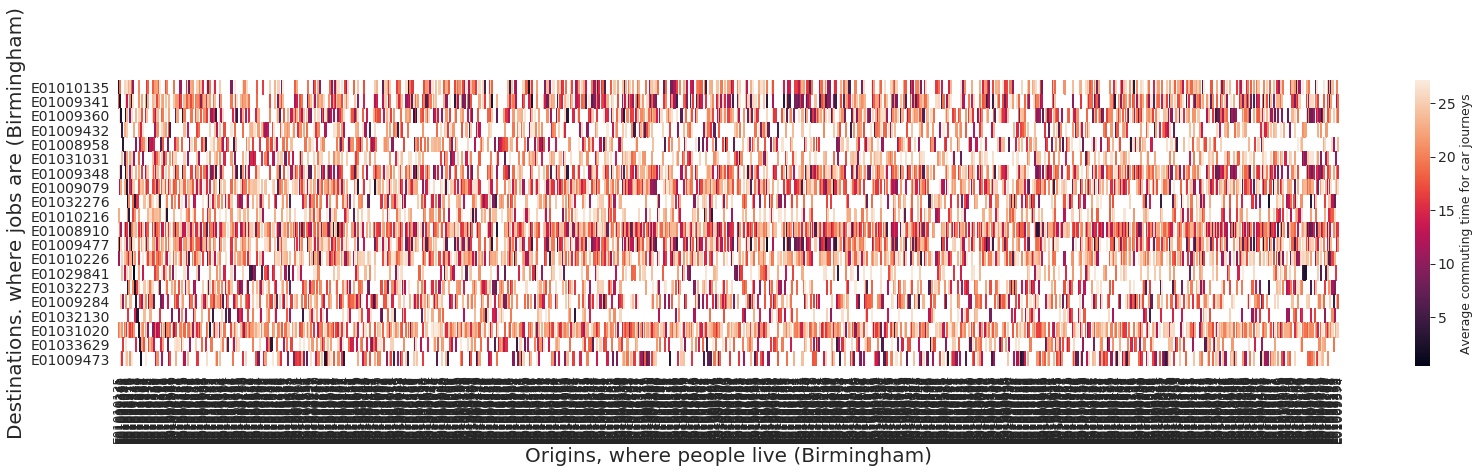

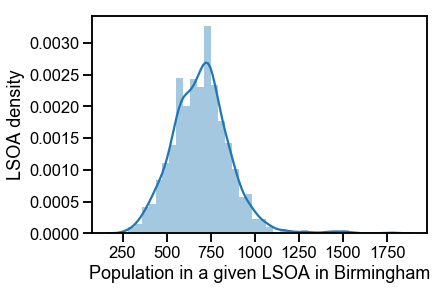

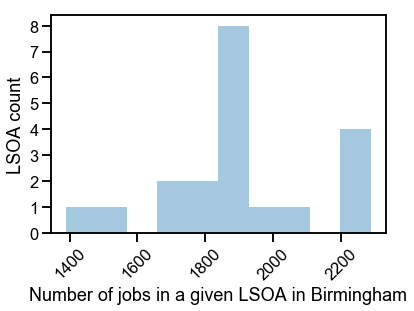

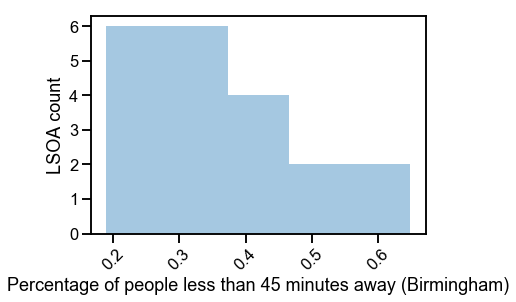

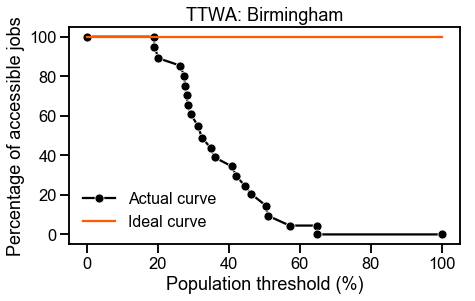

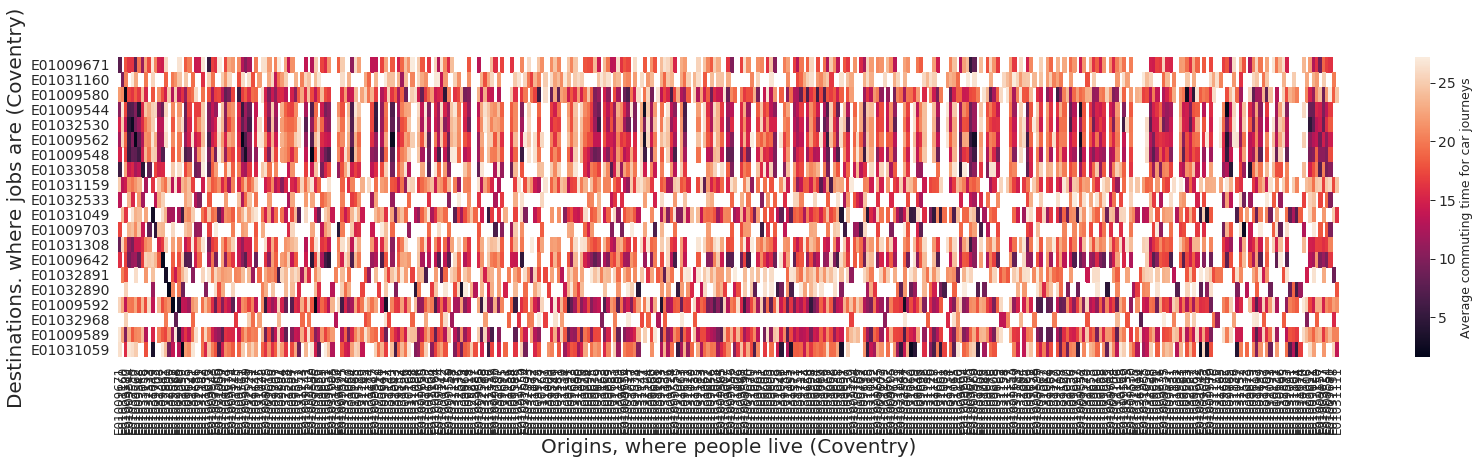

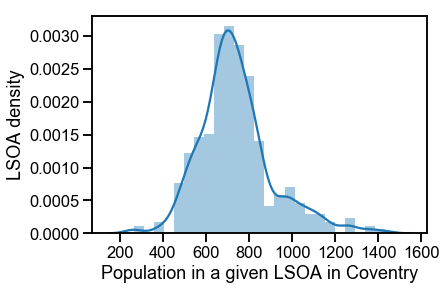

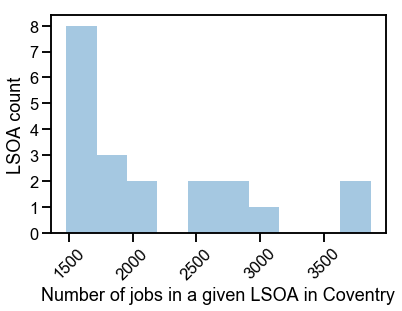

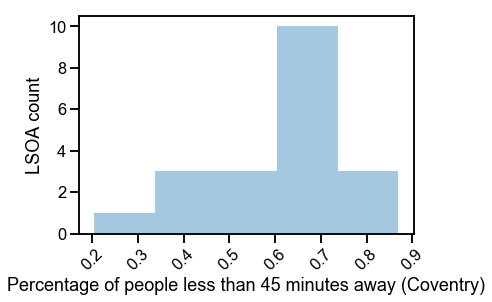

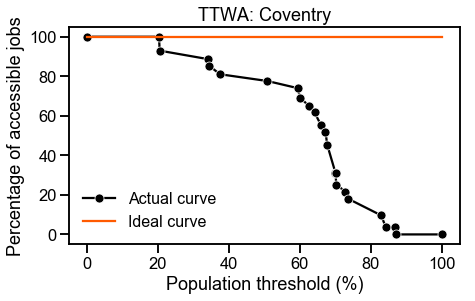

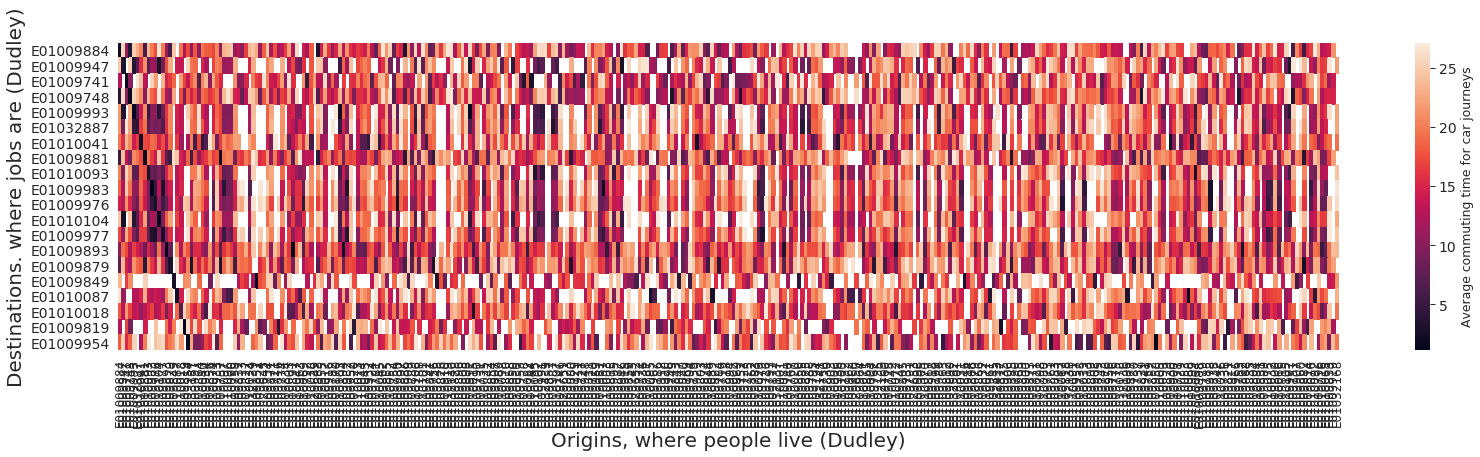

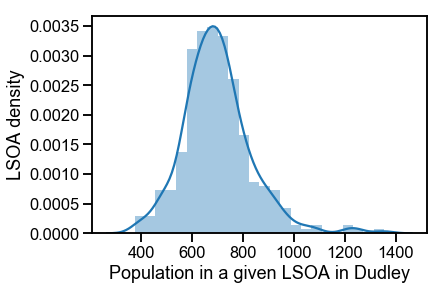

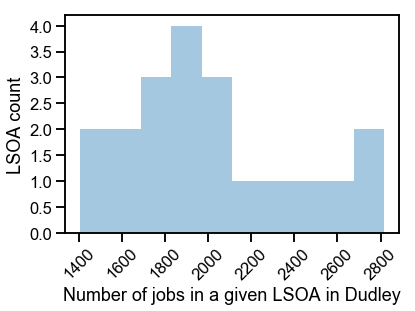

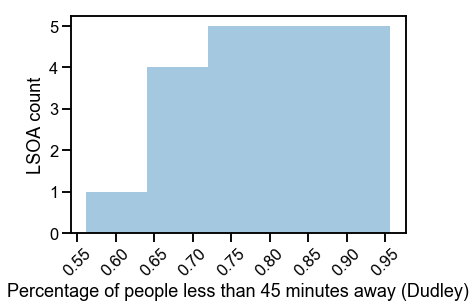

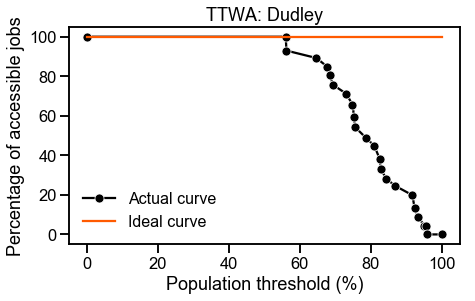

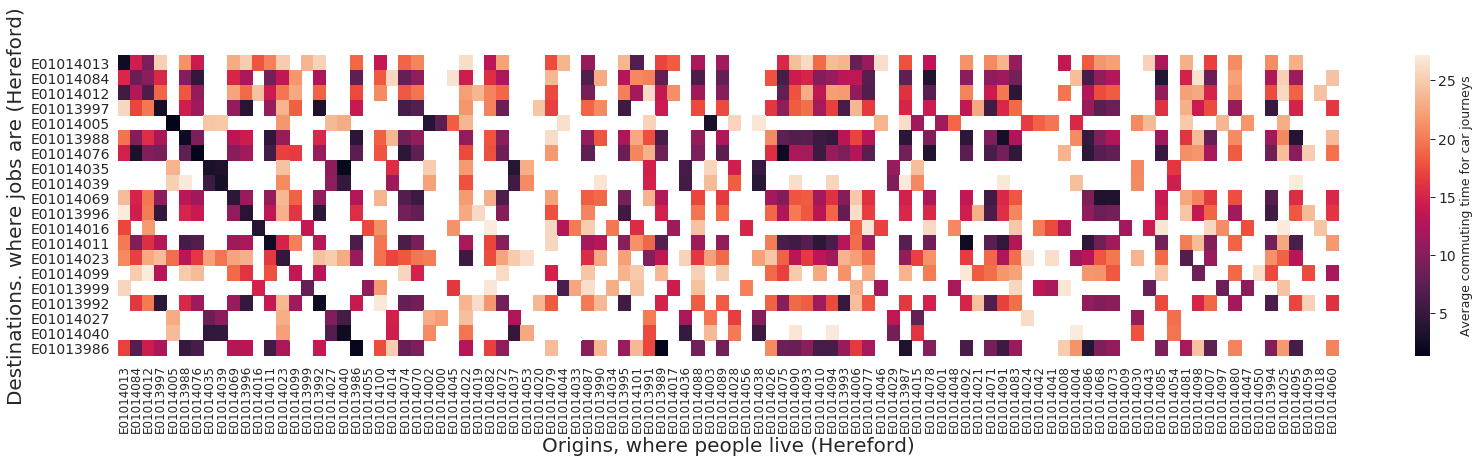

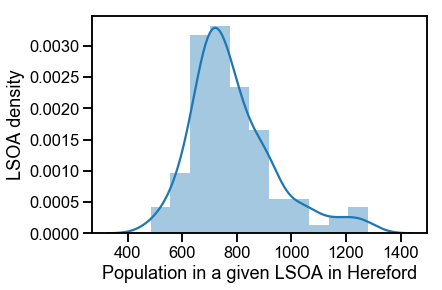

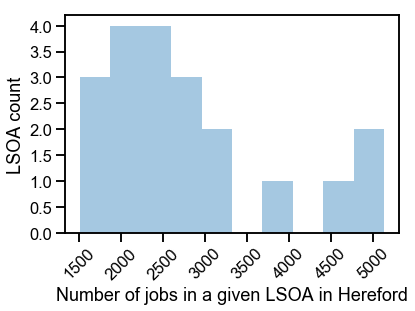

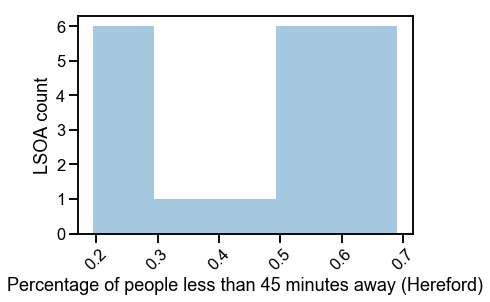

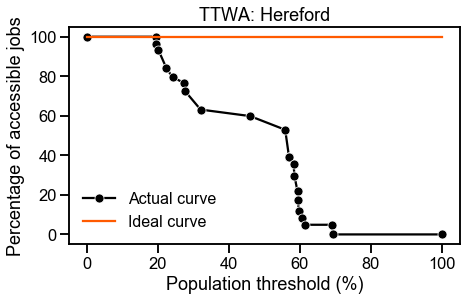

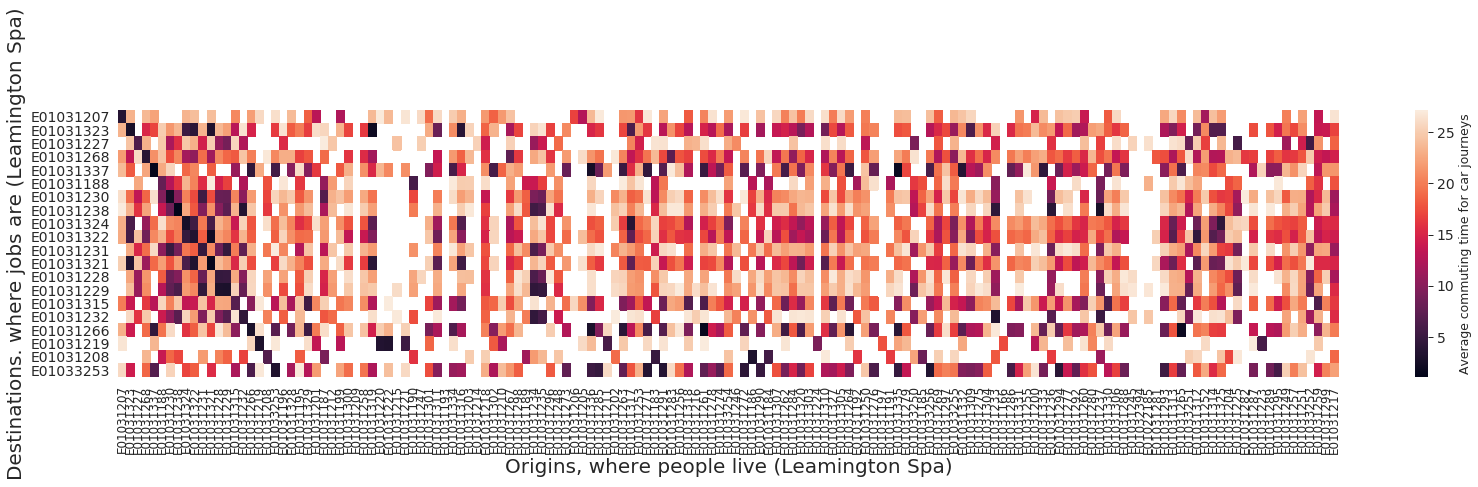

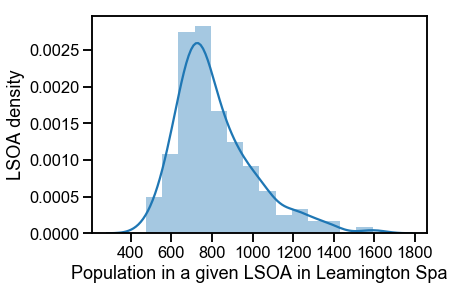

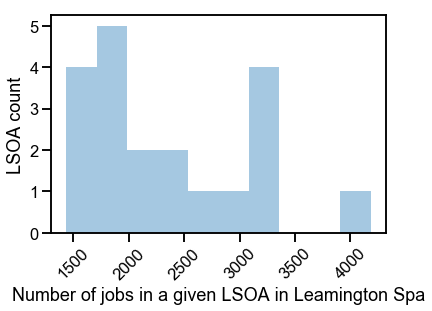

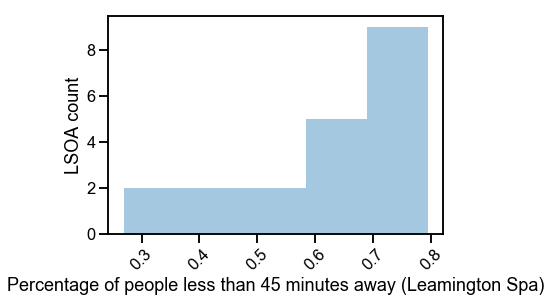

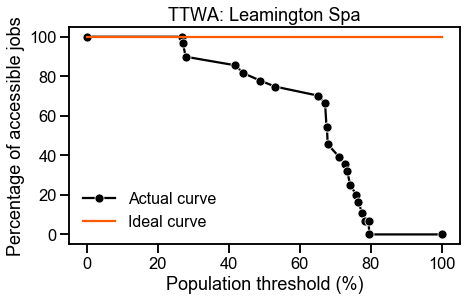

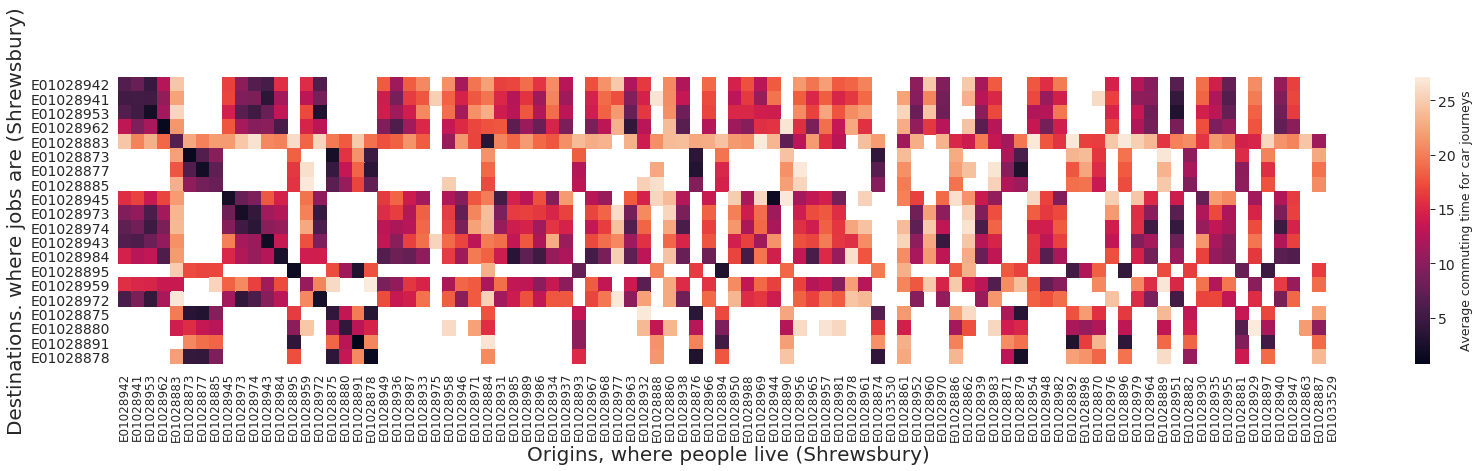

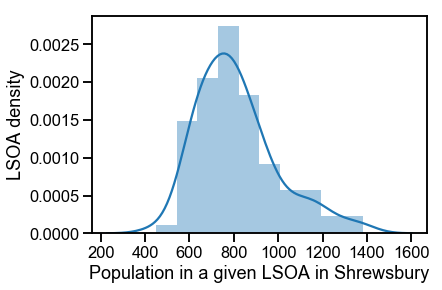

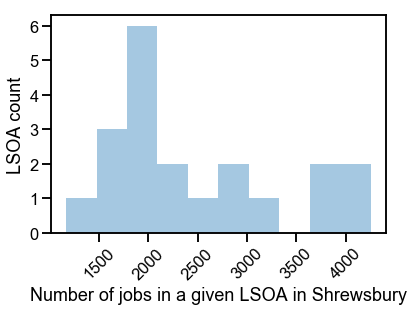

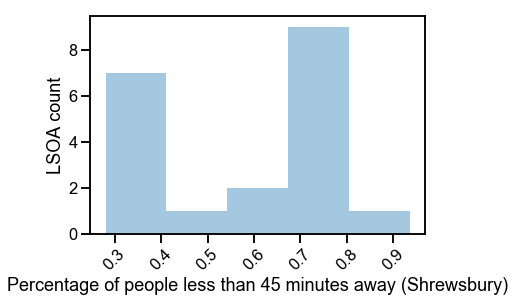

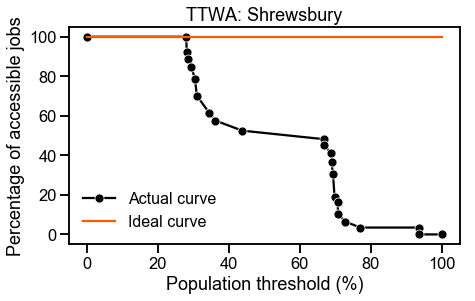

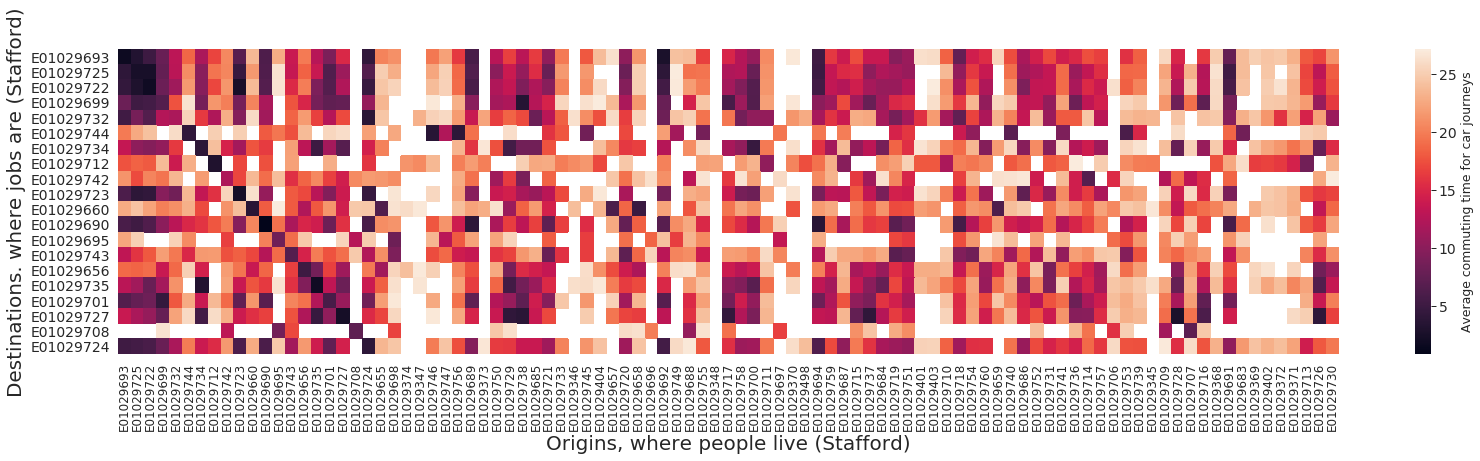

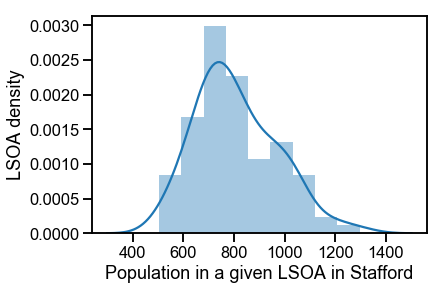

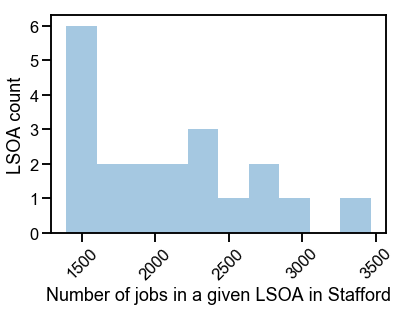

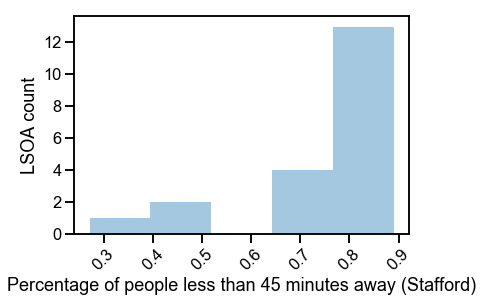

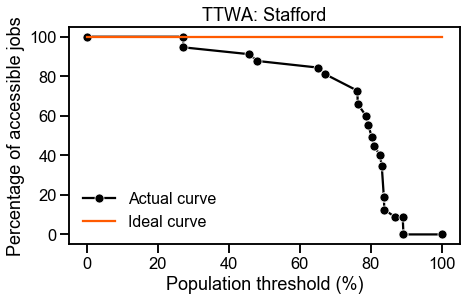

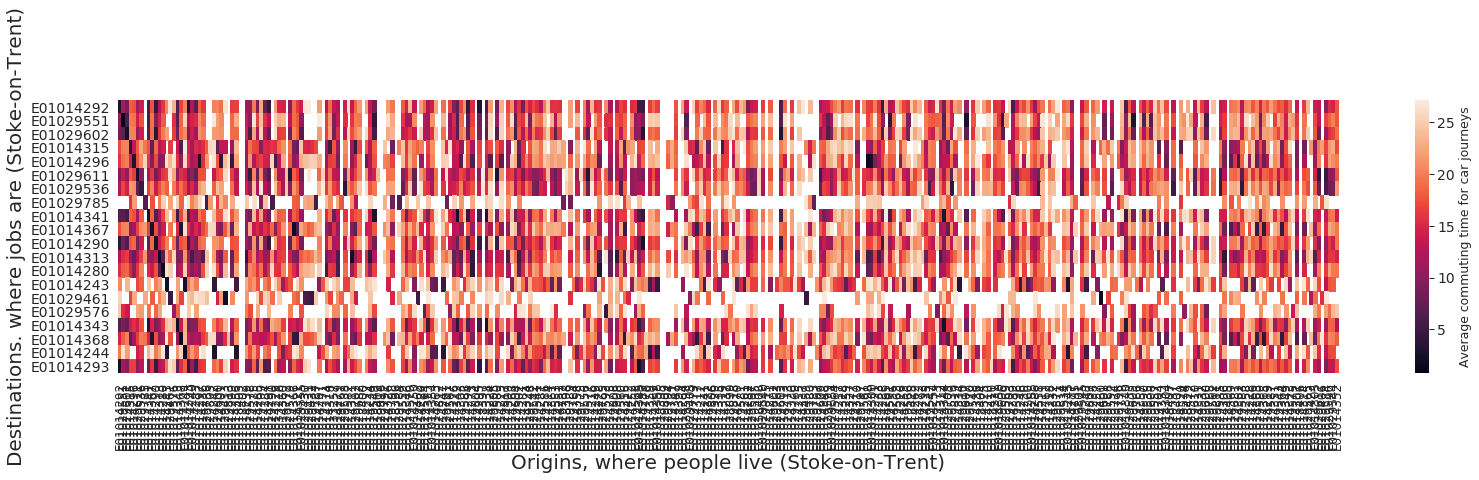

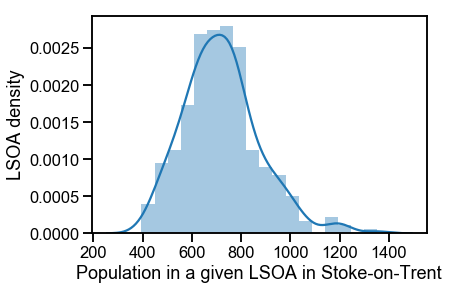

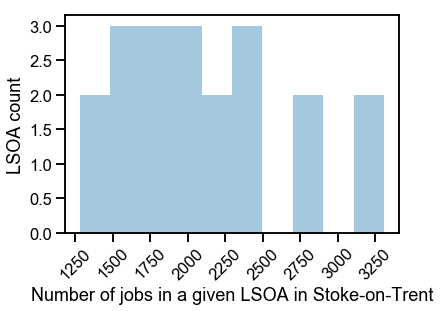

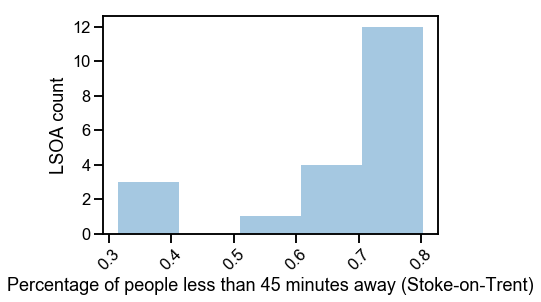

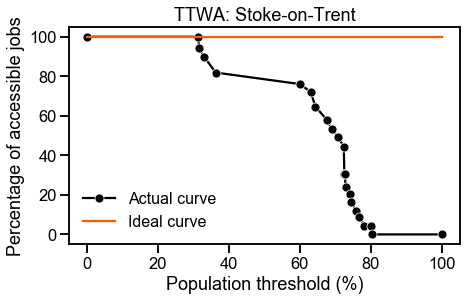

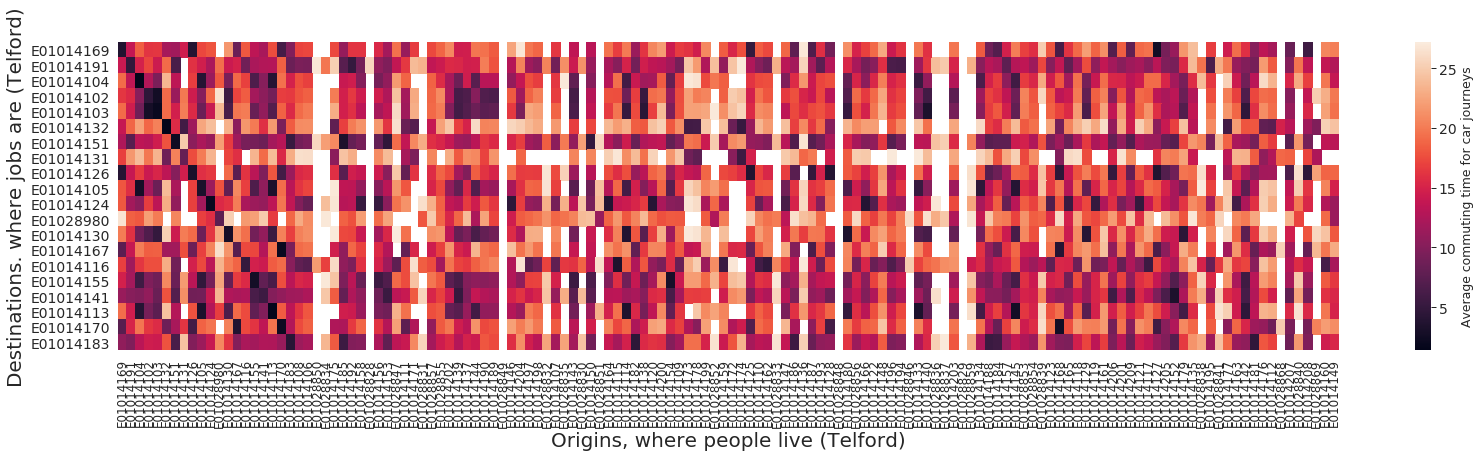

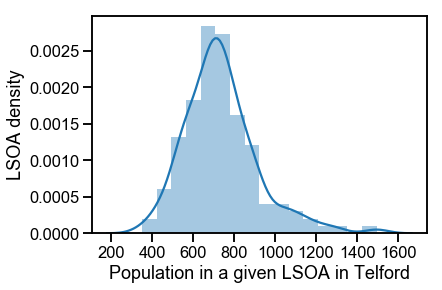

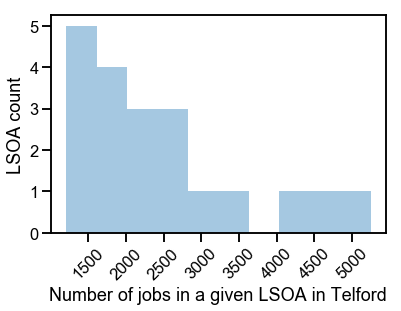

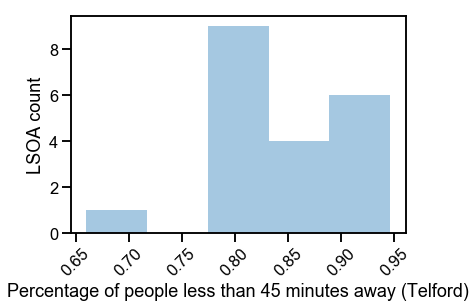

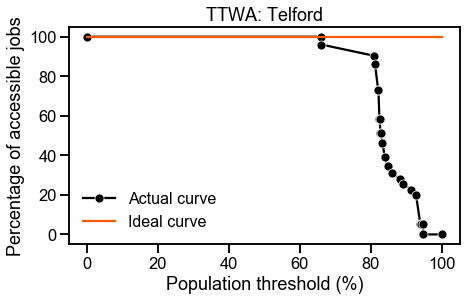

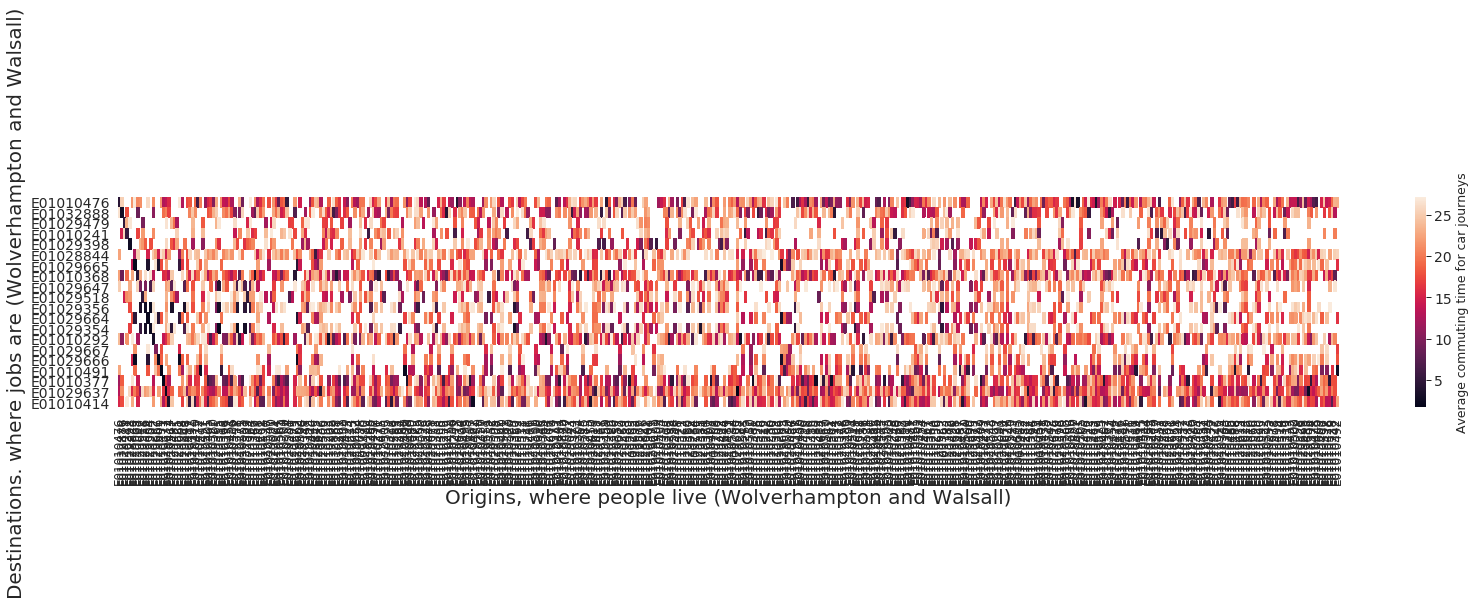

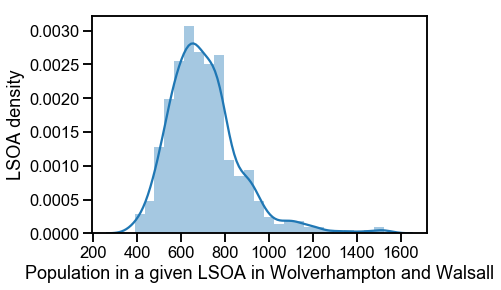

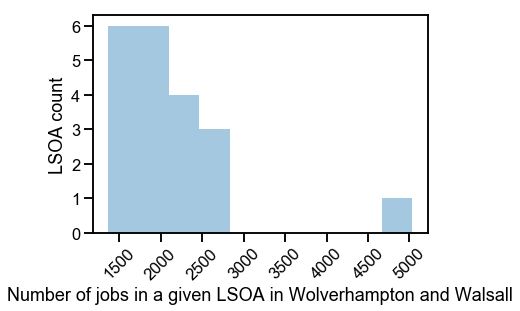

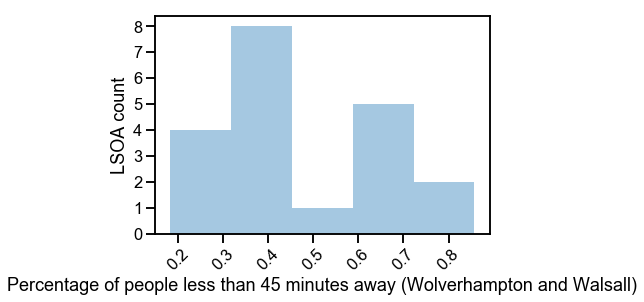

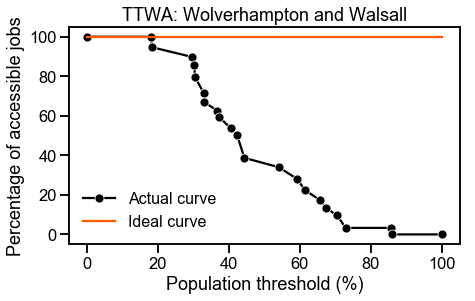

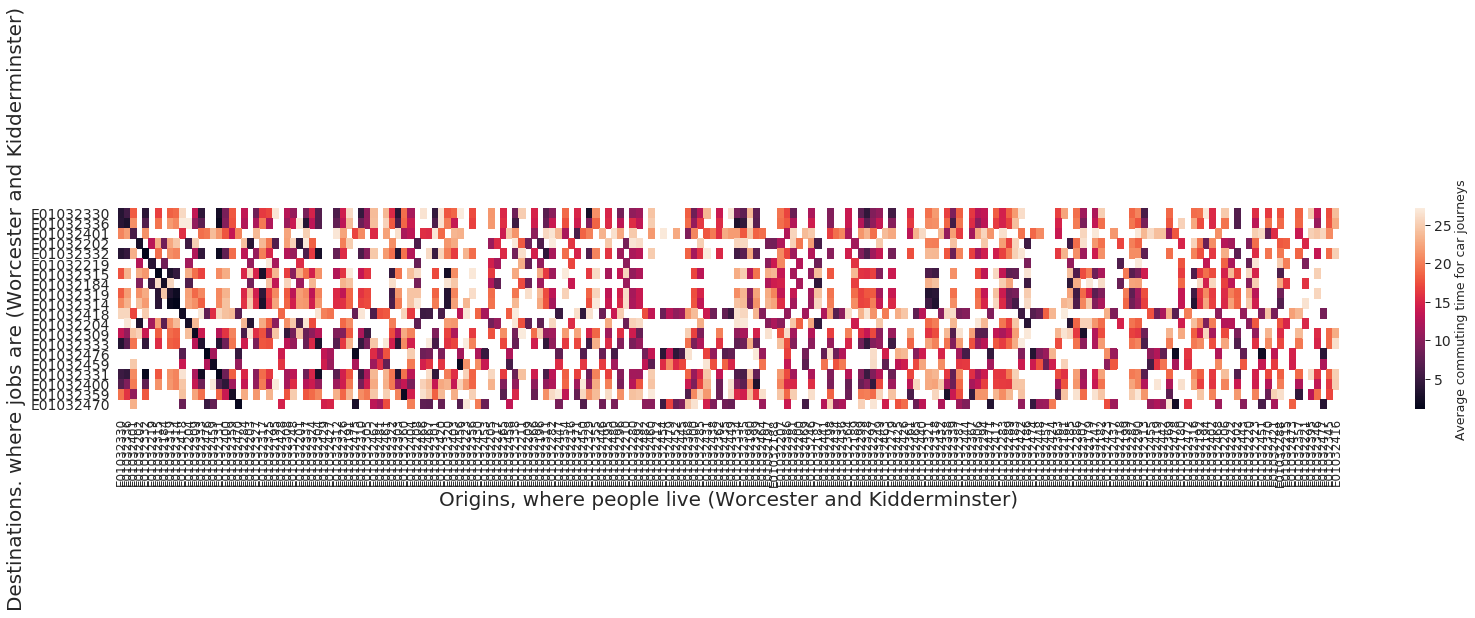

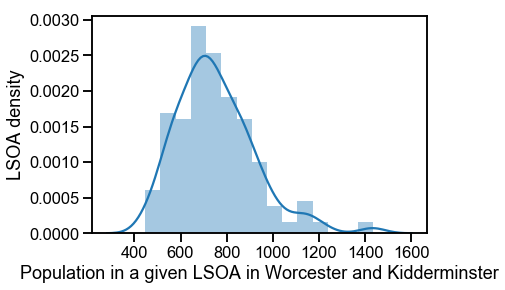

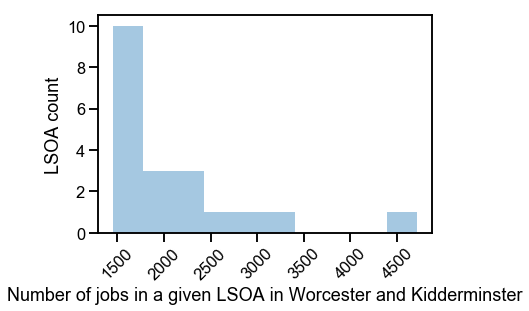

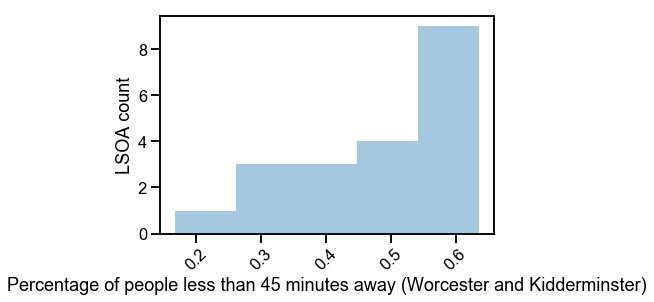

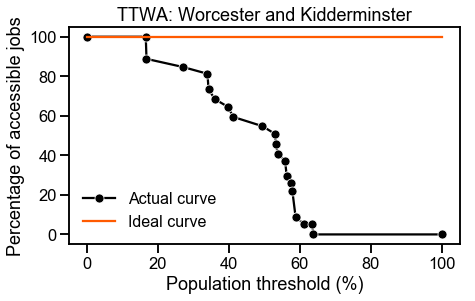

In [51]:
t0 = time.time()
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    local_lsoa = lsoa_data[lsoa_data['ttwa']==ttwa_code].join(local_lsoas_number_of_jobs[ttwa]).sort_values(
            'number of jobs', ascending = False)

    # plot the heatmap
    plot_durations_heatmap(all_durations[ttwa_code], Th, origin_lsoas[ttwa_code], dest_lsoas[ttwa_code],
                      ttwa_formal_names[ttwa], lmodes, plot_save_dir = plot_save_dir, SAVEFIG = SAVEFIG)
    
    # plot population histogram
    plot_population_hist(commute_measures[ttwa_code]['population_vector'], ttwa_formal_names[ttwa], 
                         plot_save_dir = plot_save_dir, SAVEFIG = SAVEFIG)
    
    # plot jobs vector
    plot_jobs_hist(commute_measures[ttwa_code]['jobs_vector'], ttwa_formal_names[ttwa], 
                    plot_save_dir = plot_save_dir, SAVEFIG = SAVEFIG, t_rotation = 45, nbins = 10)
    
    # to plot hist of destination accessibility 
    plot_dest_accessibility_hist(commute_measures[ttwa_code]['Ajt'], ttwa_formal_names[ttwa], lmodes, 
                    plot_save_dir = plot_save_dir, SAVEFIG = SAVEFIG, t_rotation = 45, nbins = 5)
    
    # plot accessibility curve
    plot_commute_curve(commute_measures[ttwa_code]['EofC2_vector'], commute_measures[ttwa_code]['ms'], 
                        ttwa_formal_names[ttwa], lmodes, plot_save_dir = plot_save_dir, SAVEFIG = SAVEFIG)
print_elapsed(t0, 'plotting all non-map graphs')
plt.close('all')

In [55]:
plt.close('all')

In [202]:
# get the conversion : map sizes to km
from shapely.geometry import shape
# import lsoa shapefile
A= fiona.open(lsoa_ew_filename)
# get the first two LSOAs - get their centroids - get distance between them in "map units"
scales = []
for ii in range(200):
    ix1 = np.random.randint(5000) #30*ii
    ix2 = np.random.randint(5000) #40*ii + 1
    while ix2 == ix1:
        ix2 = np.random.randint(5000)
    centroid1 = np.array(shape(A[ix1]['geometry']).centroid)#.wkt
    centroid2 = np.array(shape(A[ix2]['geometry']).centroid)#.wkt
    map_distance = np.sqrt(((centroid1 - centroid2)**2).sum())
    lsoacode1 = A[ix1]['properties']['lsoa11cd']
    lsoacode2 = A[ix2]['properties']['lsoa11cd']
    # get the distance in km between the two centroids
    coords_1 = (lsoa_data['lat'].loc[lsoacode1],lsoa_data['lon'].loc[lsoacode1])
    coords_2 = (lsoa_data['lat'].loc[lsoacode2],lsoa_data['lon'].loc[lsoacode2])
    world_unit = geodesic(coords_1, coords_2).km
    scales.append(1/world_unit * map_distance)
    #print('{:.4f} km = {:.4f} units'.format(world_unit, map_distance))
    if ii<10:
        print('{:.4f} km = {:.4f} units'.format(1, 1/world_unit * map_distance))
np.mean(scales)

1.0000 km = 998.6745 units
1.0000 km = 998.8224 units
1.0000 km = 1002.1824 units
1.0000 km = 1002.8182 units
1.0000 km = 999.9658 units
1.0000 km = 1006.9419 units
1.0000 km = 1000.2573 units
1.0000 km = 1004.0449 units
1.0000 km = 997.9280 units
1.0000 km = 1001.9631 units


999.9454297475213

Time spent on plotting all maps is 94.995s


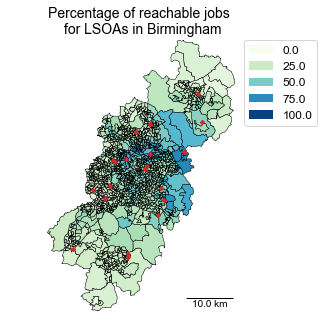

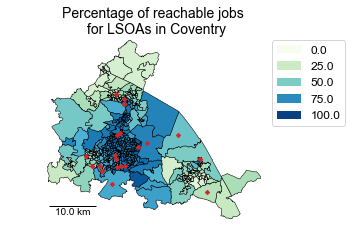

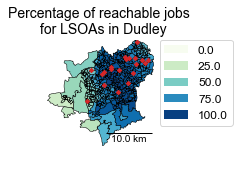

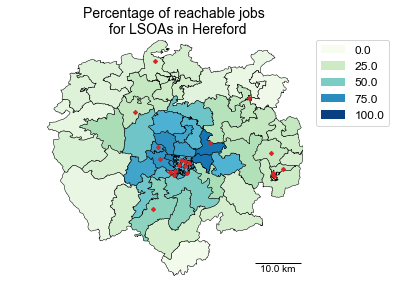

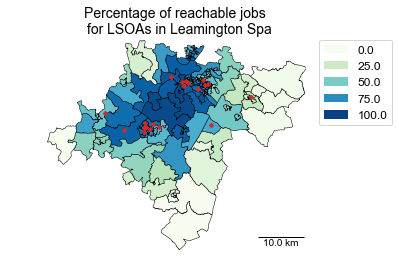

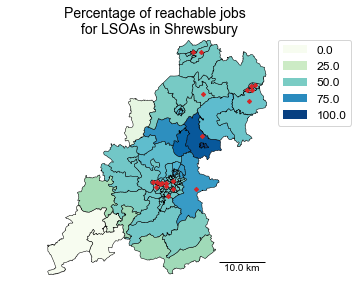

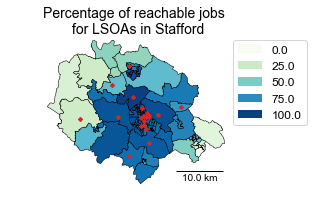

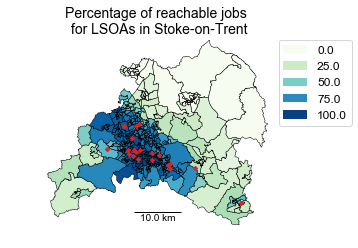

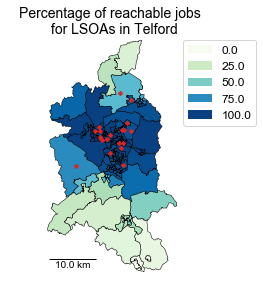

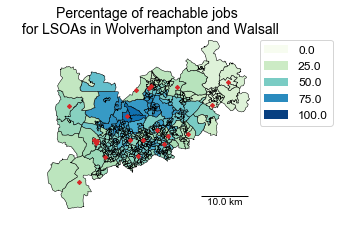

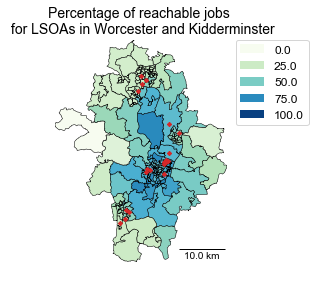

In [203]:
# plot cumulative accessibility as a map
reload(maputils_pin)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
km_show = 10.
scalebar_size = np.around(km_show * np.mean(scales)) #np.around(km_show/world_unit * map_distance,3)
def plot_accessibility_map(Bit_df, lsoa_ew_filename, dest_lsoas, ttwa_name, mode, marker_style = None,
                          plot_save_dir = '', SAVEFIG = False, which_api = 'OTP'):
    reload(maputils_pin)
    w = 8
    fig,ax = plt.subplots(figsize = (w,14))
    if not marker_style:
        marker_style = dict(color='tab:red', linestyle=':', marker='D',
                        markersize=3, markerfacecoloralt='tab:red',
                        fillstyle = 'full')
        legend_args = dict(fontsize = 12, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    _,_,xs,ys,order = maputils_pin.draw_map_and_landmarks(Bit_df, 'jobs percentage', 'GnBu', 0, 100, None,
             None, lsoa_ew_filename, roi_col = 'lsoacd', shp_col = 'lsoa11cd', fig = fig, ax = ax,
             params={'SAVEFIG': False}, landmarks = dest_lsoas, marker_style = marker_style, add_names = False,
             shp_name_col = 'lsoa11nm', legend_args = legend_args)
    w = (max(xs) - min(xs))/12000
    h = w * (max(ys)-min(ys))/(max(xs)-min(xs))
    fig.set_size_inches(w,h, forward=True)
    tmp = ax.set_title('Percentage of reachable jobs \n for LSOAs in {}'.format(ttwa_name), fontsize = 14)
    if ttwa_name in ['Telford', 'Coventry']:
        scalebar_position = 'lower left'
    elif ttwa_name in ['Stoke-on-Trent']:
        scalebar_position = 'lower center'
    else: 
        scalebar_position = 'lower right'
    scalebar = AnchoredSizeBar(ax.transData,
                           scalebar_size, '{} km'.format(km_show), scalebar_position, 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=2)
    ax.add_artist(scalebar)
    if SAVEFIG:
        plt.savefig(os.path.join(plot_save_dir,'reachable_jobs_by_origin_LSOA_{}_{}_{}.png'.format(
            ttwa_name,mode,which_api)), bbox_inches = 'tight', dpi = 300)
    plt.draw()
    return xs, ys, order

t0 = time.time()
reload(maputils_pin)
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    #local_lsoa = lsoa_data[lsoa_data['ttwa']==ttwa_code].join(local_lsoas_number_of_jobs[ttwa]).sort_values(
    #        'number of jobs', ascending = False)
    # plot accessibility on a map
    xs, ys, order = plot_accessibility_map(commute_measures[ttwa_code]['Bit_df'], lsoa_ew_filename, 
                                           dest_lsoas[ttwa_code], 
                                    ttwa_formal_names[ttwa], lmodes, marker_style = None,
                                  plot_save_dir = plot_save_dir, SAVEFIG = SAVEFIG or True)
    ## plot feasible journeys
    #plot_feasible_edges(xs, ys, order, origin_lsoas[ttwa_code], 
    #                    origin_lsoas_coord[ttwa_code], all_durations[ttwa_code])
print_elapsed(t0, 'plotting all maps')



In [218]:
plt.close('all')

In [225]:
# print a table with 25th / 50th and 75th percentile of percentage of jobs reachable from each LSOA
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    x = commute_measures[ttwa_code]['Bit']
    print(regional_ttwa['ttwa11nm'].loc[ttwa], '{:.2f} {:.2f} {:.2f} {:.2f}'.format(
        min(x), np.median(x), max(x), np.std(x)))

Birmingham 0.00 36.43 78.18 13.20
Coventry 11.81 70.97 95.67 22.25
Dudley 24.21 83.83 100.00 17.99
Hereford 3.29 53.13 82.51 23.00
Leamington Spa 0.00 69.47 96.66 26.28
Shrewsbury 0.00 52.49 100.00 13.47
Stafford 3.34 86.41 100.00 24.99
Stoke-on-Trent 0.00 79.36 100.00 31.50
Telford 0.00 100.00 100.00 26.17
Wolverhampton and Walsall 13.83 47.68 84.56 13.94
Worcester and Kidderminster 0.00 45.46 79.08 17.24


In [228]:
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    print(commute_measures[ttwa_code]['EofC1min'])

0.0010738686648654244
0.003220634245581255
0.003271298422056626
0.010879120943526985
0.008085324082236299
0.011743560737598299
0.011995059223742688
0.0031870836392829628
0.007921101145659448
0.0028482767537991315
0.004829225120543078


In [59]:
# print the scores
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    local_lsoa = lsoa_data[lsoa_data['ttwa']==ttwa_code].join(local_lsoas_number_of_jobs[ttwa]).sort_values(
            'number of jobs', ascending = False)  
    # print some scores
    print_scores(ttwa_formal_names[ttwa], commute_measures[ttwa_code]['EofC1'], 
                 commute_measures[ttwa_code]['EofC1norm'], commute_measures[ttwa_code]['EofC2'], 
                 commute_measures[ttwa_code]['EofC2_vector'], commute_measures[ttwa_code]['m'], 
                 commute_measures[ttwa_code]['ms'])
    print_scores_to_file(plot_save_dir, ttwa_formal_names[ttwa], commute_measures[ttwa_code]['EofC1'], 
                 commute_measures[ttwa_code]['EofC1norm'], commute_measures[ttwa_code]['EofC2'], 
                 commute_measures[ttwa_code]['EofC2_vector'], commute_measures[ttwa_code]['m'], 
                 commute_measures[ttwa_code]['ms'])
    print('-'*117)
    print('\n')

Overall, Birmingham has an ease of commute score nb. 1 of 0.366
Overall, Birmingham has a normalised ease of commute score nb. 1 of 0.365
Overall, Birmingham has an ease of commute score nb. 2 of 20.5%. That is, this is the percentage of jobs that can be reached by at least 50% of the population within the time constraint
The maximum percentage of population that can access all jobs within the threshold is 18.83%
The minimum population percentage for which the percentage of accessible jobs is lower than 50% is 32.42%
---------------------------------------------------------------------------------------------------------------------


Overall, Coventry has an ease of commute score nb. 1 of 0.626
Overall, Coventry has a normalised ease of commute score nb. 1 of 0.624
Overall, Coventry has an ease of commute score nb. 2 of 81.0%. That is, this is the percentage of jobs that can be reached by at least 50% of the population within the time constraint
The maximum percentage of population th

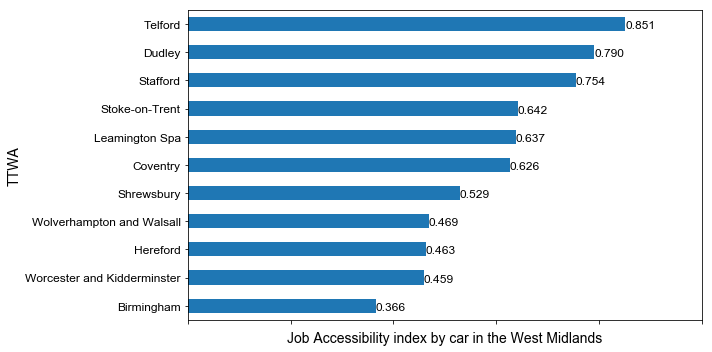

In [232]:
# now some plots for the entire region
# Print out a table with the different EofC scores

'''
# normalised index
tmp_df = pd.DataFrame.from_dict(commute_measures, orient= 'index', columns = ['EofC1norm', 'name']).sort_values(
    by = 'EofC1norm')
print(tmp_df)
# now plot this as a bar chart
plt.figure(figsize = (10,5))
tmp_df['EofC1norm'].plot(kind = 'barh')
plt.xlim([0,1])
tmp= plt.gca().set_yticklabels(tmp_df['name'], fontsize = 12)
plt.xlabel('Jobs accessibility index by {} in {}'.format(lmodes,region_name), fontsize = 14)
plt.ylabel('TTWA', fontsize = 14)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize = 12)
for ix,val in enumerate(tmp_df['EofC1norm'].values):
    plt.text(val,ix-.15,'{:.3f}'.format(val), fontsize = 12)
plt.tight_layout()
'''
# plot un-normalised score
tmp_df = pd.DataFrame.from_dict(commute_measures, orient= 'index', columns = ['EofC1', 'name']).sort_values(
    by = 'EofC1')
plt.figure(figsize = (10,5))
tmp_df['EofC1'].plot(kind = 'barh')
plt.xlim([0,1])
tmp= plt.gca().set_yticklabels(tmp_df['name'], fontsize = 12)
plt.xlabel('Job Accessibility index by {} in the {}'.format(lmodes,region_name), fontsize = 14)
plt.ylabel('TTWA', fontsize = 14)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize = 12)
for ix,val in enumerate(tmp_df['EofC1'].values):
    plt.text(val,ix-.15,'{:.3f}'.format(val), fontsize = 12)
plt.tight_layout()

if SAVEFIG or True:
    plt.savefig(os.path.join(plot_save_dir, 'jobs_accessibility_index_notnorm_by_{}_in_{}'.format(
        lmodes,region_name.replace(' ',''))), bbox_inches = 'tight', dpi = 300)
    


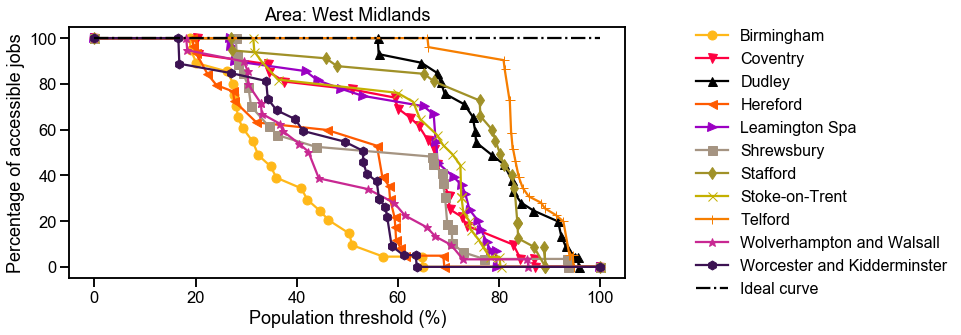

In [61]:
# plot a graph with the EofC curves for all the TTWAs + the ideal curve
reload(utils_pin)
markers_list = ['o','v','^','<','>','s','d','x','+','*','h','o']
from utils_pin import nesta_colours, nesta_colours_combos
def plot_multiple_commute_curves(commute_measures_dict, area_name, mode, plot_save_dir = '', 
                                SAVEFIG = False, which_api = 'OTP'):
    assert(isinstance(commute_measures_dict,dict))
    ks = commute_measures_dict.keys()
    ic = -1
    ideal_curve_colour = 2
    # plot EofC2 vs m
    with sns.plotting_context("talk"):
        fig, ax = plt.subplots(figsize=(14,5))
        for key in ks:
            ic += 1
            #if ic == ideal_curve_colour:
            #    ic+=1
            plt.plot(commute_measures_dict[key]['ms']*100, 
                         commute_measures_dict[key]['EofC2_vector']*100, color=nesta_colours[ic], 
                         marker = markers_list[ic], label = commute_measures_dict[key]['name'])
        plt.plot(ms*100, 100 + np.zeros_like(ms), '-.', markerfacecolor = 'none', 
                 color = nesta_colours[ideal_curve_colour], label = 'Ideal curve')
        plt.xlabel('Population threshold (%)')
        plt.ylabel('Percentage of accessible jobs')
        plt.title('Area: the {}'.format(area_name))
        plt.legend(fontsize= 16, frameon = False, bbox_to_anchor=(1.1, 1.05))
        # think about the interpretation again +  check R + 
        plt.tight_layout()
    if SAVEFIG or True:
        plt.savefig(os.path.join(plot_save_dir,'ease_of_commute_score2_distribution_{}_{}_{}.png'.format(
            area_name.replace(' ',''),mode,which_api)), bbox_inches = 'tight', dpi = 300)
    plt.draw()
    
plot_multiple_commute_curves(commute_measures, region_name, lmodes,plot_save_dir = plot_save_dir,
                            SAVEFIG = SAVEFIG)


In [62]:
# get the average commuting distance
groups = oa_data.groupby('ttwa')
M_dist_ttwa = np.zeros(len(regional_ttwa.index))
M_dist_ttwa2 = {}
for jj,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    # get the group corresponding to this TTWA
    group = groups.get_group(ttwa_code)
    # collect the mean distances to work
    dks = np.array(group['Mean distance to work (overall)'])
    # go through all the occupations
    M_dist_ttwa[jj] = np.nanmean(dks)
    M_dist_ttwa2[ttwa_code] = np.nanmean(dks)
print(M_dist_ttwa)



[ 8.90340702  9.63073258  8.28453436  9.51426794 11.22712227 10.65060462
 11.20882417  9.42817342 10.36829149  9.41163502 10.59271145]


In [212]:
# rearrange the data into a dataframe
print(commute_measures['E30000271'].keys())
commute_df = pd.DataFrame.from_dict(commute_measures, orient = 'index', columns = ['name', 'EofC1', 'EofC1norm', 
                                                                                'ms', 'EofC2_vector'])
commute_df = commute_df.join(pd.DataFrame.from_dict(flying_crow, orient = 'index', 
                                                    columns = ['all geographical distances'])).join(
                        pd.DataFrame.from_dict(M_dist_ttwa2, orient = 'index', columns = ['commute distance'])).join(
                        pd.DataFrame.from_dict(avg_ons_times, orient = 'index', columns = ['avg ons times']))
commute_df['geographical distance'] = commute_df['all geographical distances'].map(np.mean)
print(commute_df.head(n=3))



dict_keys(['name', 'population_vector', 'population_vector_norm', 'jobs_vector', 'jobs_vector_norm', 'Bit', 'Bit_df', 'Ajt', 'Wjt', 'EofC1', 'EofC1min', 'EofC1norm', 'm', 'EofC2', 'ms', 'EofC2_vector'])
                 name     EofC1  EofC1norm  \
E30000169  Birmingham  0.366015   0.365333   
E30000195    Coventry  0.625621   0.624412   
E30000202      Dudley  0.790249   0.789560   

                                                          ms  \
E30000169  [0.0, 0.18830394127112382, 0.19030394127112382...   
E30000195  [0.0, 0.2031872855969019, 0.2051872855969019, ...   
E30000202  [0.0, 0.5601538184910497, 0.5621538184910497, ...   

                                                EofC2_vector  \
E30000169  [0.9999999999999999, 0.9999999999999999, 0.949...   
E30000195  [1.0, 1.0, 0.9296739807572506, 0.8863431854364...   
E30000202  [1.0, 1.0, 0.9299079372978352, 0.8923612839014...   

                                  all geographical distances  \
E30000169  [[0.0, 0.57169781303696

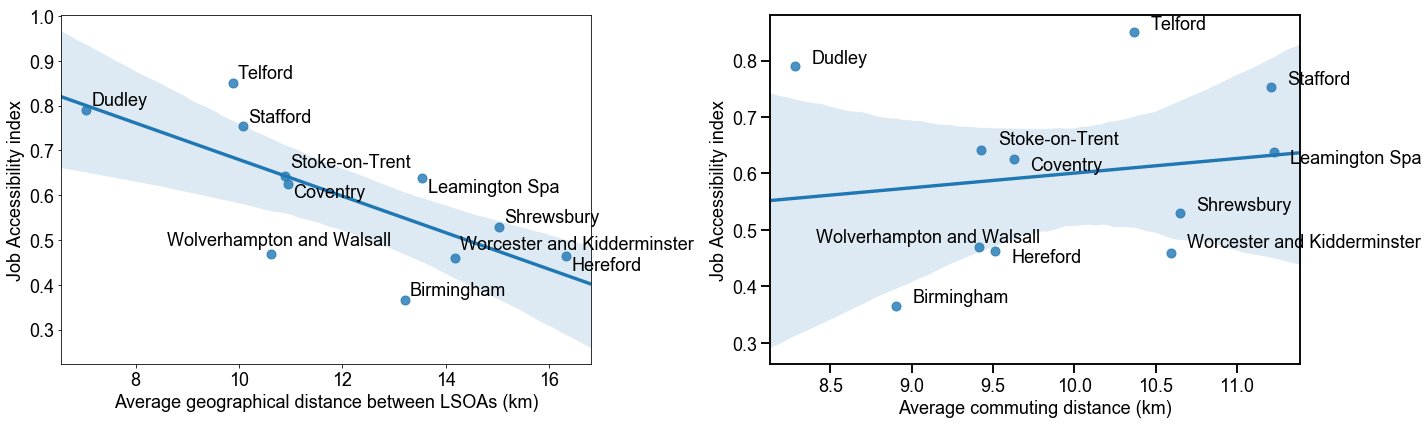

In [230]:
markers_list = ['o','v','^','<','>','s','d','x','+','*','h','o']
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1,2,1)
jaindex = 'EofC1'
commute_df['geographical distance km'] = commute_df['geographical distance'].map(lambda x: x*1.609344)
with sns.plotting_context('talk'):
    g = sns.regplot(x = 'geographical distance km', y = jaindex, data = commute_df, ax = ax1)
    for t,ttwa in enumerate(regional_ttwa.index):
        ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
        x = flying_crow[ttwa_code].mean()*1.609344
    #    plt.plot(flying_crow[ttwa_code].mean(),commute_measures[ttwa_code]['EofC1norm'],'o', 
    #             color = nesta_colours[2])
        if commute_measures[ttwa_code]['name'] in ['Coventry','Hereford','Leamington Spa']:
            plt.text(x+.1,commute_measures[ttwa_code][jaindex]-.03,
                 commute_measures[ttwa_code]['name'])
        elif 'Wolverhampton' in commute_measures[ttwa_code]['name']:
            plt.text(x-2,commute_measures[ttwa_code][jaindex]+.02,
                 commute_measures[ttwa_code]['name'])
        elif commute_measures[ttwa_code]['name'] in ['Stoke-on-Trent', 'Worcester and Kidderminster']:
            plt.text(x+.1,commute_measures[ttwa_code][jaindex]+.02,
                 commute_measures[ttwa_code]['name'])
        else:
            plt.text(x+.1,commute_measures[ttwa_code][jaindex]+.01,
                 commute_measures[ttwa_code]['name'])
    plt.xlabel('Average geographical distance between LSOAs (km)', fontsize = 18)
    plt.ylabel('Job Accessibility index', fontsize = 18)
    ax1.tick_params(axis = 'both', labelsize = 18)
    ax2 = fig.add_subplot(122)
    g = sns.regplot(x = 'commute distance', y = jaindex, data = commute_df, ax = ax2)
    for t,ttwa in enumerate(regional_ttwa.index):
        ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
        #plt.plot(M_dist_ttwa[t],commute_measures[ttwa_code]['EofC1norm'],'o', color = nesta_colours[1])
        if commute_measures[ttwa_code]['name'] in ['Coventry','Hereford','Leamington Spa']:
            plt.text(M_dist_ttwa[t]+.1,commute_measures[ttwa_code][jaindex]-.02,
                 commute_measures[ttwa_code]['name'])
        elif 'Wolverhampton' in commute_measures[ttwa_code]['name']:
            plt.text(M_dist_ttwa[t]-1,commute_measures[ttwa_code][jaindex]+.01,
                 commute_measures[ttwa_code]['name'])
        elif commute_measures[ttwa_code]['name'] in ['Stoke-on-Trent', 'Worcester and Kidderminster']:
            plt.text(M_dist_ttwa[t]+.1,commute_measures[ttwa_code][jaindex]+.01,
                 commute_measures[ttwa_code]['name'])
        else:
            plt.text(M_dist_ttwa[t]+.1,commute_measures[ttwa_code][jaindex]+.005,
                 commute_measures[ttwa_code]['name'])
        plt.xlabel('Average commuting distance (km)', fontsize = 18)
        plt.ylabel('Job Accessibility index', fontsize = 18)
    ax2.tick_params(axis = 'both', labelsize = 18)
plt.tight_layout()
# save if needed
if SAVEFIG or True:
    plt.savefig(os.path.join(plot_save_dir,'jobs_accessibility_index_nonnorm_vs_distances_{}_{}_{}.png'.format(
            region_name.replace(' ',''),lmodes,'OTP')), bbox_inches = 'tight', dpi = 300)




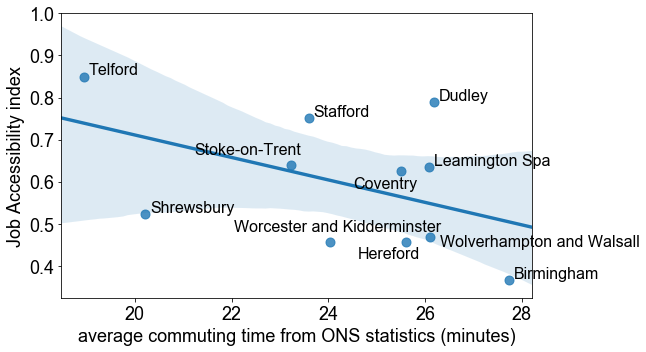

In [231]:
# now plot accessibility index versus average commuting times from ons
fig= plt.figure(figsize = (9,5))
ax= fig.gca()
jaindex = 'EofC1'
with sns.plotting_context('talk'):
    g = sns.regplot(x = 'avg ons times', y = 'EofC1norm', data = commute_df, ax = ax)
    for t,ttwa in enumerate(regional_ttwa.index):
        ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
        #plt.plot(M_dist_ttwa[t],commute_measures[ttwa_code]['EofC1norm'],'o', color = nesta_colours[1])
        if commute_measures[ttwa_code]['name'] in ['Coventry','Hereford']:
            plt.text(avg_ons_times[ttwa_code]-1,commute_measures[ttwa_code]['EofC1norm']-.04,
                 commute_measures[ttwa_code]['name'], fontsize = 16)
        elif 'Wolverhampton' in commute_measures[ttwa_code]['name']:
            plt.text(avg_ons_times[ttwa_code]+.2,commute_measures[ttwa_code]['EofC1norm']-.02,
                 commute_measures[ttwa_code]['name'], fontsize = 16)
        elif commute_measures[ttwa_code]['name'] in ['Stoke-on-Trent', 'Worcester and Kidderminster']:
            plt.text(avg_ons_times[ttwa_code]-2,commute_measures[ttwa_code]['EofC1norm']+.025,
                 commute_measures[ttwa_code]['name'], fontsize = 16)
        else:
            plt.text(avg_ons_times[ttwa_code]+.1,commute_measures[ttwa_code]['EofC1norm']+.005,
                 commute_measures[ttwa_code]['name'], fontsize = 16)
        plt.xlabel('average commuting time from ONS statistics (minutes)', fontsize = 18)
        plt.ylabel('Job Accessibility index', fontsize = 18)
    ax.tick_params(axis = 'both', labelsize = 18)
plt.tight_layout()




In [66]:
# possibly, plot accessibility index against employment rate and claimant count (as for distances), maybe size too?
# first extract relevant TTWAs
ttwa_data['relevant'] = ttwa_data['ttwa11cd'].map(lambda x: x in list(commute_measures.keys()))
ttwa_data_red = ttwa_data[ttwa_data['relevant']]
#ttwa_data.columns



Supply-side self-containment -0.5470635401431352


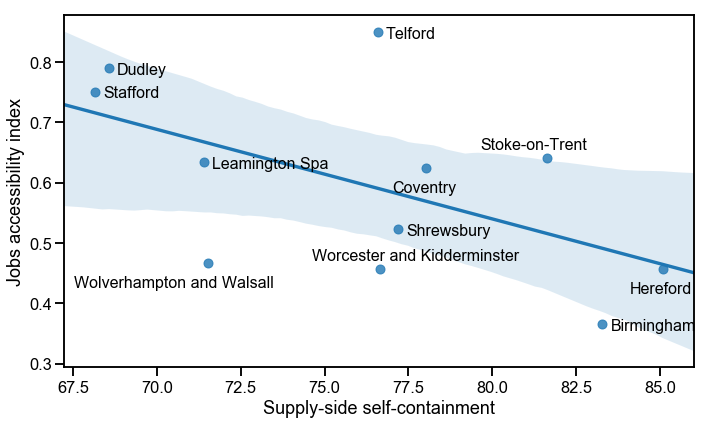

In [67]:
for col in ['Supply-side self-containment']:
#, 'Demand-side self containment','Employment rate',
#            'Male employment rate', 'Female employment rate','Job-seeking economically inactive', 'Claimant count',
#           'Employed in SOC code 1', 'Employed in SOC code 2',
#       'Employed in SOC code 5', 'Employed in SOC code 6',
#       'Employed in SOC code 8', 'Employed in SOC code 9']:
    with sns.plotting_context('talk'):
        plt.figure(figsize = (10,6))
        x = ttwa_data_red[col]
        g = sns.regplot(x,commute_df['EofC1norm'])
        try:
            rho = np.corrcoef(commute_df['EofC1norm'].values,ttwa_data_red[col].values)[0,1]
        except:
            rho = np.corrcoef(commute_df['EofC1norm'].values,ttwa_data_red[col].values.astype(np.float32))[0,1]
        #    print(col,ttwa_data_red[col].values)
        print(col, rho)
        plt.ylabel('Jobs accessibility index', fontsize = 18) #. rho={}'.format(np.around(rho,3)))
        plt.xlabel(col, fontsize = 18)
        for t,ttwa in enumerate(regional_ttwa.index):
            ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
            if commute_measures[ttwa_code]['name'] in ['Coventry','Hereford']:
                plt.text(x.loc[ttwa]-1,commute_measures[ttwa_code]['EofC1norm']-.04,
                     commute_measures[ttwa_code]['name'], fontsize = 16)
            elif 'Wolverhampton' in commute_measures[ttwa_code]['name']:
                plt.text(x.loc[ttwa]-4,commute_measures[ttwa_code]['EofC1norm']-.04,
                     commute_measures[ttwa_code]['name'], fontsize = 16)
            elif commute_measures[ttwa_code]['name'] in ['Stoke-on-Trent', 'Worcester and Kidderminster']:
                plt.text(x.loc[ttwa]-2,commute_measures[ttwa_code]['EofC1norm']+.015,
                     commute_measures[ttwa_code]['name'], fontsize = 16)
            else:
                plt.text(x.loc[ttwa]+.25,commute_measures[ttwa_code]['EofC1norm']-0.01,
                     commute_measures[ttwa_code]['name'], fontsize = 16)
plt.tight_layout()
if SAVEFIG or True:
    plt.savefig(os.path.join(plot_save_dir, 'jobs_accessibility_index_vs_containment_{}_{}_{}.png'.format(
            region_name.replace(' ',''),lmodes,'OTP')), bbox_inches = 'tight', dpi = 300)
        

### Jobs accessibility by occupation
Try to split the average travel times by occupations - basically, for each (1st digit?) SOC code, select the 10 destinations with the most jobs for that occupation and recompute the jobs accessibility index

In [616]:
# recompute commuting measures by occupations breakdown (data is contained into oa_groups)
commute_measures_occupations = {}
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    commute_measures_occupations[ttwa_code] = {}
    #commute_measures_occupations[ttwa_code]['name'] = ttwa_formal_names[ttwa]
    # get the relevant LSOAs
    group = oa_groups[oa_groups['ttwa'] == ttwa_code]
    # from the 20 LSOAs destinations select the 10 with the highest number of people employed in 
    # that occupation (using 1st digit SOC codes). Obviously, we might be missing some LSOAs with
    # high number of workers in certain occupations
    for digit in ['1','2','3','4','5','6','7','8','9']: #cols_by_digits.keys():
        #print(digit)
        top_lsoas = group[digit + '_value'].loc[dest_lsoas[ttwa_code]].sort_values(ascending = False)[:10]
        # Computing the jobs vectors is easy
        jobs_vector = np.array(top_lsoas.values)
        jobs_vector_norm = jobs_vector / np.sum(jobs_vector)
        # now keep the LSOA codes only
        top_lsoas = list(top_lsoas.index)
        # find indices of top_lsoas from the original destination list
        top_index = [dest_lsoas[ttwa_code].index(t) for t in top_lsoas]
        #print(top_index, dest_lsoas[ttwa_code],top_lsoas)
        # recompute all the other relevant quantities
        # population vectors
        population_vector, population_vector_norm, _, _ = compute_jobs_and_population(
                                    origin_lsoas[ttwa_code], lsoa_data, oa_data, top_lsoas, 
                                    local_lsoas_number_of_jobs[ttwa])

        # jobs accessibility measures
        # need to adjust the durations matrix first
        durations_matrix = all_durations[ttwa_code][top_index,:]
        Bit,Bit_df,Ajt,Wjt,EofC1,EofC1min,EofC1norm, m, EofC2, ms, EofC2_vector = get_cumulative_accessibility_measures(
                                durations_matrix, Th, jobs_vector_norm, 
                                population_vector_norm, origin_lsoas[ttwa_code], top_lsoas)
        # store all into a very nested dictionary
        commute_measures_occupations[ttwa_code][digit] = {}
        commute_measures_occupations[ttwa_code][digit]['name'] = 'SOC: {}'.format(digit) #
        # store the quantities
        for var in ['population_vector', 'population_vector_norm', 'jobs_vector', 'jobs_vector_norm', 'Bit', 'Bit_df',
                    'Ajt','Wjt','EofC1','EofC1min','EofC1norm', 'm', 'EofC2', 'ms', 'EofC2_vector']:
            exec('commute_measures_occupations[ttwa_code][digit][var] = ' + var)



/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less
/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:197: RuntimeWarning: invalid value encountered in less


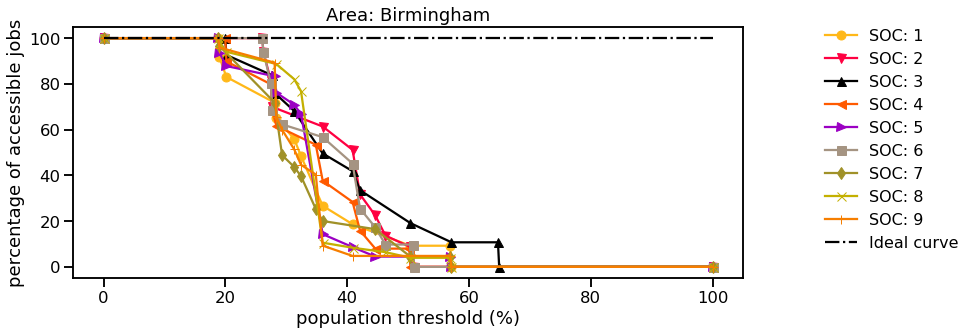

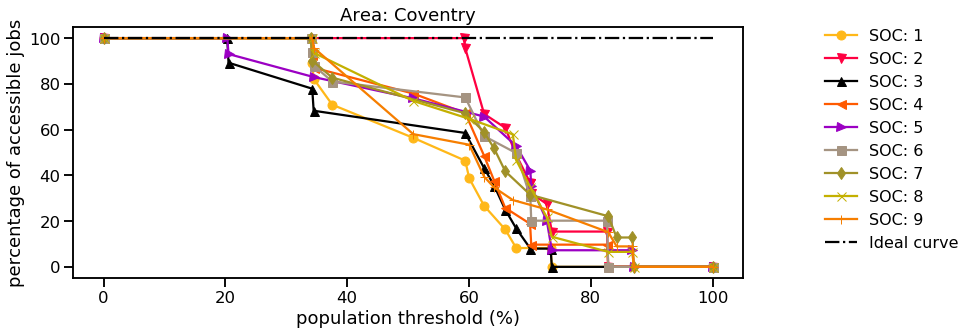

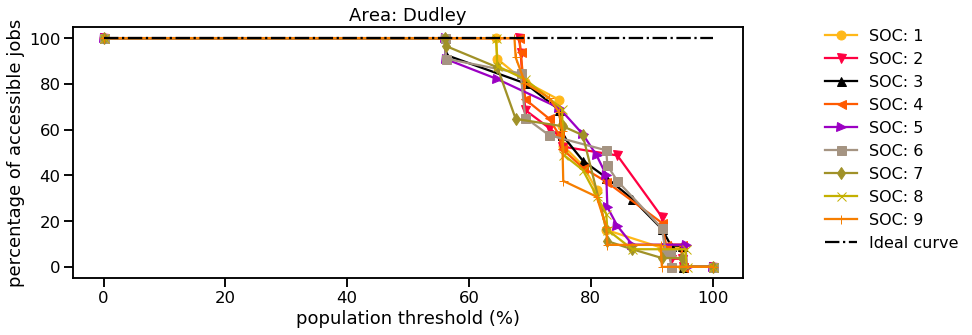

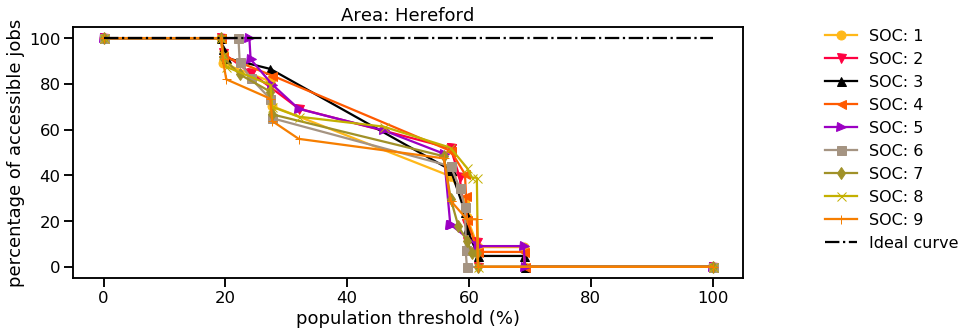

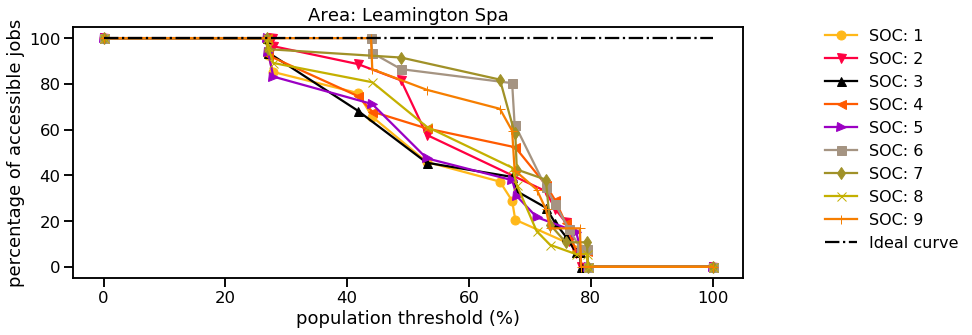

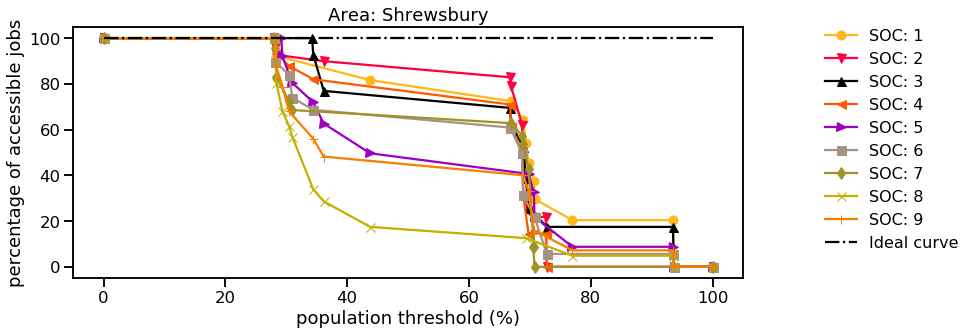

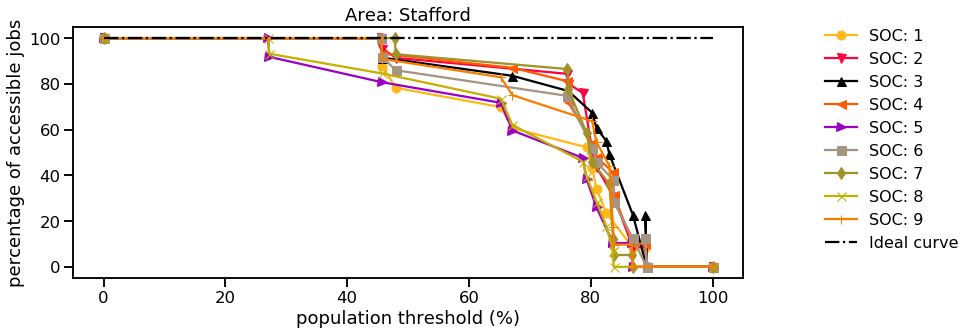

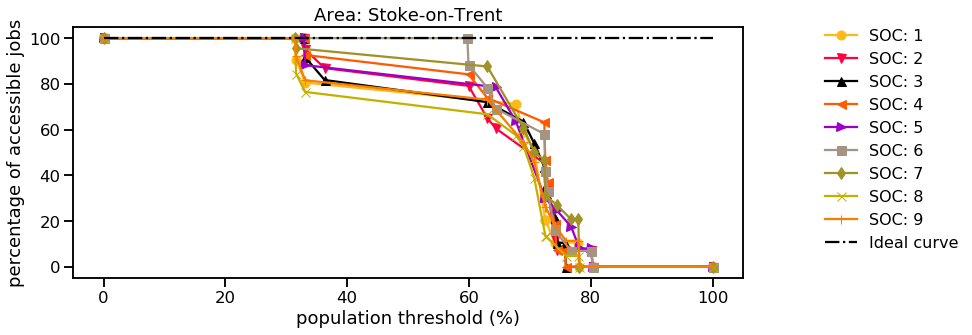

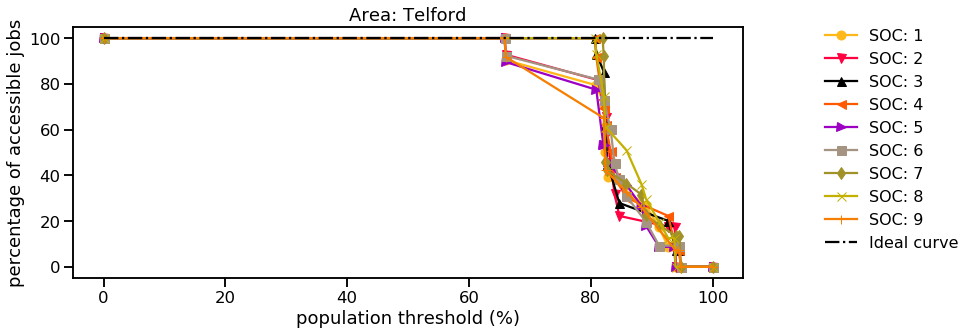

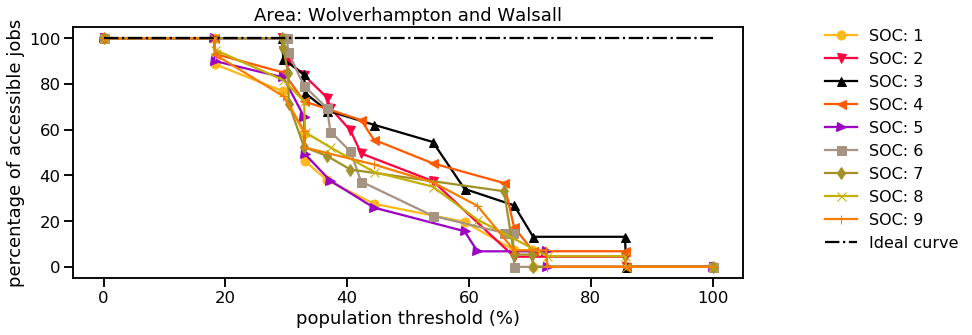

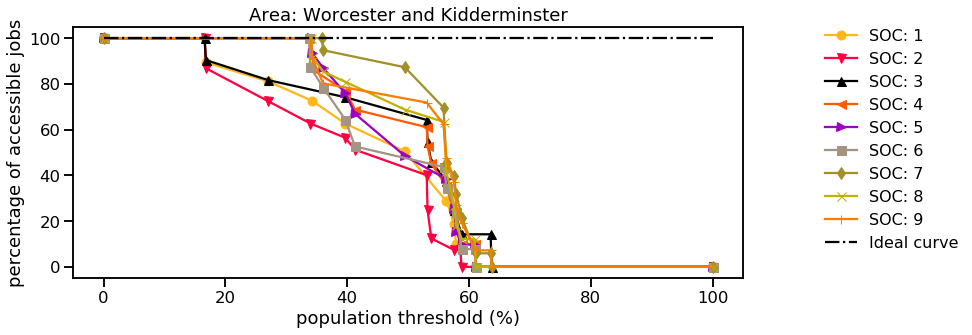

In [618]:
# plot a graph with the EofC curves for all the TTWAs + the ideal curve
reload(utils_pin)
markers_list = ['o','v','^','<','>','s','d','x','+','*','h','o']
from utils_pin import nesta_colours, nesta_colours_combos
for t,ttwa in enumerate(regional_ttwa.index):
    ttwa_code = regional_ttwa['ttwa11cd'].loc[ttwa]
    plot_multiple_commute_curves(commute_measures_occupations[ttwa_code], 
                             regional_ttwa['ttwa11nm'].loc[ttwa], lmodes,
                             plot_save_dir = plot_save_dir, SAVEFIG = False)



